Part I. Insepecting residuals

Function definition:

In [1]:
import numpy as np

def fractional_residual(z_measured, z_model):
    """
    This function computes the fractional residual of a given observed height and a model prediction.
    It takes in two parameters.
    
    Args:
        z_measured (float): measured height [in arcsec].
        z_model (float): model prediction of height[in arcsec]. It cannot be zero
        
    Returns:
        This function returns the fractional residual.
    """
    residual = (z_measured - z_model) / z_model
    return residual

In [2]:
import numpy as np
from scipy.optimize import curve_fit

def tapered_power_law(r_in, z0_in, Psi_in, r_taper_in, Phi_in):
    """
    This function computes the "tapered" power-law function.
    It takes in five parameters.
    
    Args:
        zo_in (float): input scale height [in arcsec].
        r_in (float): input list of the radii[in arcsec] we are observing.
        Psi_in (float): a unitless parameter.
        r_taper_in (float): input "tapered" radius [in arcsec].
        Phi_in (float): another unitless parameter.
        
    Returns:
        This function returns the height[in arcsec].
    """
    height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
    return height_z

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation
from itertools import product

def best_fit_curve_and_datapoints(path_in, r_in, z0_in, Psi_in, r_taper_in, Phi_in, color_array_in, c_lower_in, c_upper_in):
    """
    This function plots best fit curves over datapoints spanning across several user-decideded channels.
    It takes in nine parameters.
    
    Args:
        path_in (str): name[no units] of directory holding the real ALMA observational images.
        zo_in (float/list): input scale height [in arcsec].
        r_in (float/list): input list of the radii[in arcsec] we are observing.
        Psi_in (float/list): a unitless parameter.
        r_taper_in (float/list): input "tapered" radius [in arcsec].
        Phi_in (float/list): another unitless parameter.
        color_array_in (list): input list of colors.
        c_lower_in (float): lower boundary of the channel range [in km/s] picked by user.
        c_upper_in (float): upper boundary of the channel range [in km/s] picked by user.
        
    Returns:
        This function returns nothing.
    """
    HD163296_molecule = disk_observation(path_in)
    r, z, Fnu, velocity, x, yf, yn = HD163296_molecule.get_emission_surface_v2(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5, min_Fnu = 0.0025)
    fig = plt.figure(figsize=(100, 130))
    for index, velo in enumerate(np.unique(velocity)):
        if round(velo / 1000., 2) >= c_lower_in and round(velo / 1000., 2) <= c_upper_in:
            rvals_tofit = r[np.where(velocity==velo)]
            zvals_tofit = z[np.where(velocity==velo)]
            i = 0
            ax = plt.subplot(7, 8, index+1)
            ax.scatter(rvals_tofit, zvals_tofit,s=2)
            ax.set_xlabel('r (arcsec)')
            ax.set_ylabel('z (arcsec)')
            ax.set_xlim(left = 0, right=5)
            ax.text(0.75, 0.9, "%.2f km/s" % (velo/1000.), transform=ax.transAxes)
            for count, value in enumerate(product(z0_in, Psi_in, r_taper_in, Phi_in)):
                popt, cov = HD163296_molecule.fit_emission_surface(rvals_tofit, zvals_tofit, curve_fit_kwargs = {'p0': np.array([value[0], value[1], value[2], value[3]])})
                ax.plot(r_in, tapered_power_law(r_in, popt[0], popt[1], popt[2], popt[3]), 'r--', color=color_array_in[i], label='z0 = ' + str(value[0]) + ' , ψ= ' + str(value[1]) + ' , r_taper = ' + str(value[2]) + ' , φ = ' + str(value[3]))
                i = i + 1
                ax.legend()
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation

def plotting_fractional_residual(path_in, r_in, z0_in, Psi_in, r_taper_in, Phi_in, c_lower_in, c_upper_in):
    """
    This function plots the residuals from the best-fit model of given range of channels.
    It takes in seven parameters.
    
    Args:
        path_in (str): name[no units] of directory holding the real ALMA observational images.
        zo_in (float/list): input scale height [in arcsec].
        r_in (float/list): input list of the radii[in arcsec] we are observing.
        Psi_in (float/list): a unitless parameter.
        r_taper_in (float/list): input "tapered" radius [in arcsec].
        Phi_in (float/list): another unitless parameter.
        c_lower_in (float): lower boundary of the channel range [in km/s] picked by user.
        c_upper_in (float): upper boundary of the channel range [in km/s] picked by user.
        
    Returns:
        This function returns nothing.
    """
    HD163296_molecule = disk_observation(path_in)
    r, z, Fnu, velocity, x, yf, yn = HD163296_molecule.get_emission_surface_v2(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5, min_Fnu = 0.0025)
    fig = plt.figure(figsize=(100, 130))
    for index, velo in enumerate(np.unique(velocity)):
        if round(velo / 1000., 2) >= c_lower_in and round(velo / 1000., 2) <= c_upper_in:
            rvals_tofit = r[np.where(velocity==velo)]
            zvals_tofit = z[np.where(velocity==velo)]
            ax = plt.subplot(7, 8, index+1)
            ax.set_xlabel('r (arcsec)')
            ax.set_ylabel('fractional residual (arcsec)')
            ax.set_xlim(left = 0, right=5)
            ax.text(0.75, 0.9, "%.2f km/s" % (velo/1000.), transform=ax.transAxes)
            popt, cov = HD163296_molecule.fit_emission_surface(rvals_tofit, zvals_tofit, curve_fit_kwargs = {'p0': np.array([z0_in, Psi_in, r_taper_in, Phi_in])})
            z_model = tapered_power_law(rvals_tofit, popt[0], popt[1], popt[2], popt[3])
            #Picking out z_model values that are not zero. Otherwise, we will run into "divided by zero" error when computing fractional residuals.
            z_model = z_model[np.where(tapered_power_law(rvals_tofit, popt[0], popt[1], popt[2], popt[3])!=0)]
            #We also pick out r and z values corresponding to the new z_model values to make z and z_model broadcastable and r and fractional residual plotable to same shape.
            rvals_tofit = rvals_tofit[np.where(tapered_power_law(rvals_tofit, popt[0], popt[1], popt[2], popt[3])!=0)]
            zvals_tofit = zvals_tofit[np.where(tapered_power_law(rvals_tofit, popt[0], popt[1], popt[2], popt[3])!=0)]
            ax.scatter(rvals_tofit, fractional_residual(zvals_tofit, z_model), s=2)
    plt.show()

Fractional residual and best-fit model plots of HD_163296_HCN_260GHz_hf1.robust_0.5.clean.JvMcorr.image.pbcor.fits :

In [5]:
color_array = ['black', 'grey', 'red', 'peru', 'tan', 'orange', 'olive', 'yellow', 'lawngreen', 'seagreen', 'lightgreen', 'cyan', 'dodgerblue', 'navy', 'violet', 'orchid']
r = np.arange(0, 5, step=0.1)

z0_3 = [0.05]

z0 = [1.0]
Psi = [2.2]
r_taper = [4.0]
Phi = [20.0]

z0_2 = [1.0]
Psi_2 = [2.2]
r_taper_2 = [3.5]
Phi_2 = [20.0]

Phi_3 = [14.0]

c_lower = 6.26
c_upper = 7.26

c_lower_2 = 7.46
c_upper_2 = 7.46

c_lower_3 = 7.66
c_upper_3 = 7.66

c_lower_4 = 7.86
c_upper_4 = 7.86


path = '/data/shared/HD163296_MAPS/HD_163296_HCN_260GHz_hf1.robust_0.5.clean.JvMcorr.image.pbcor.fits'

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


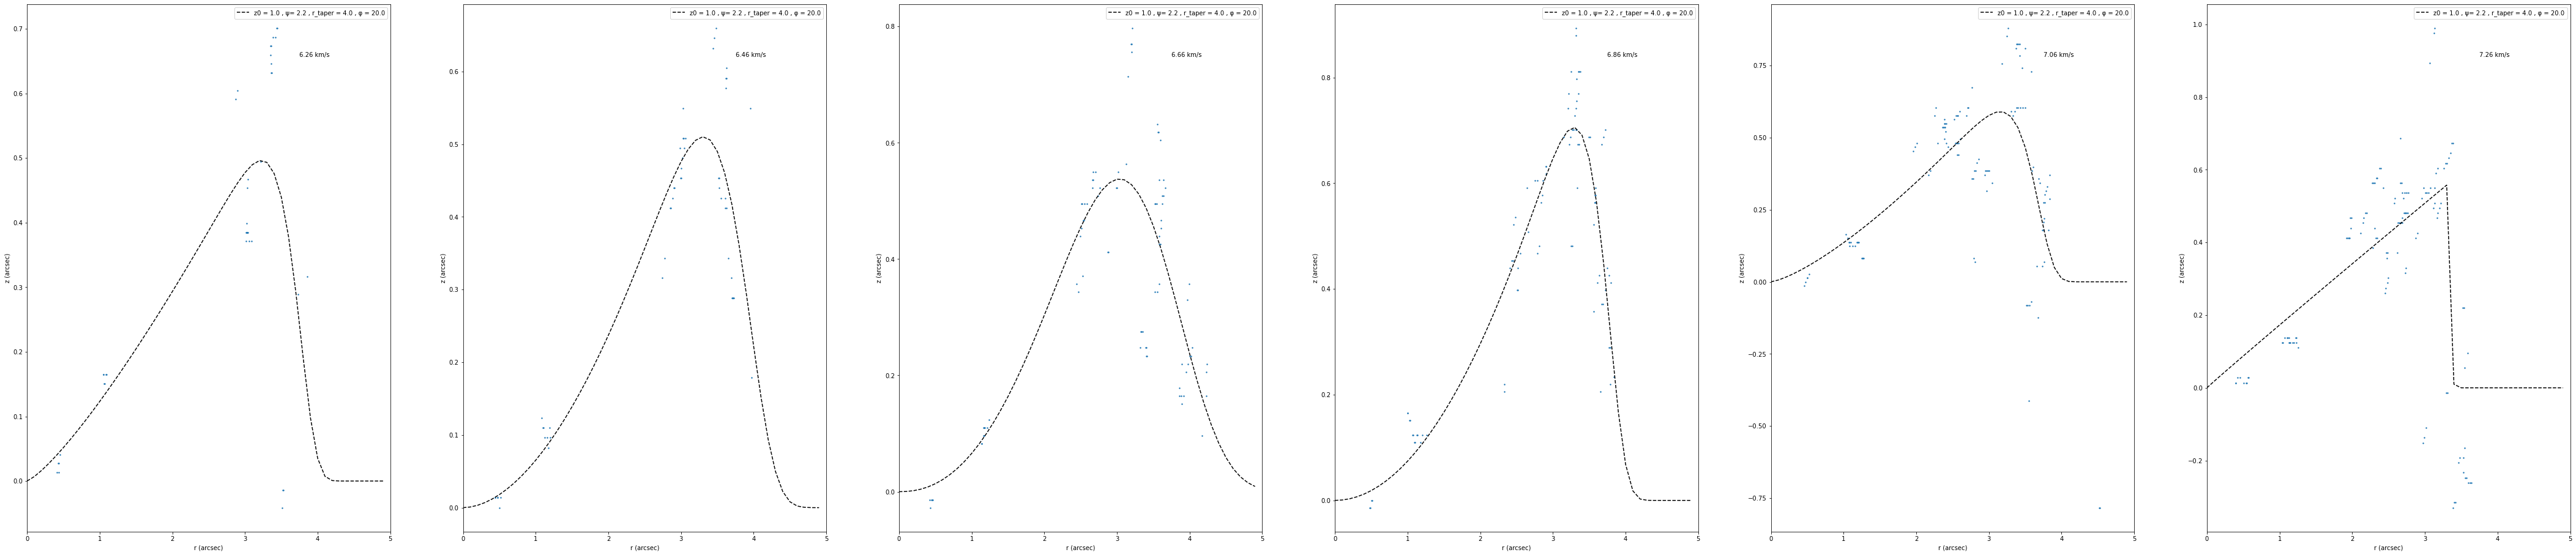

In [6]:
best_fit_curve_and_datapoints(path, r, z0, Psi, r_taper, Phi, color_array, c_lower, c_upper)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


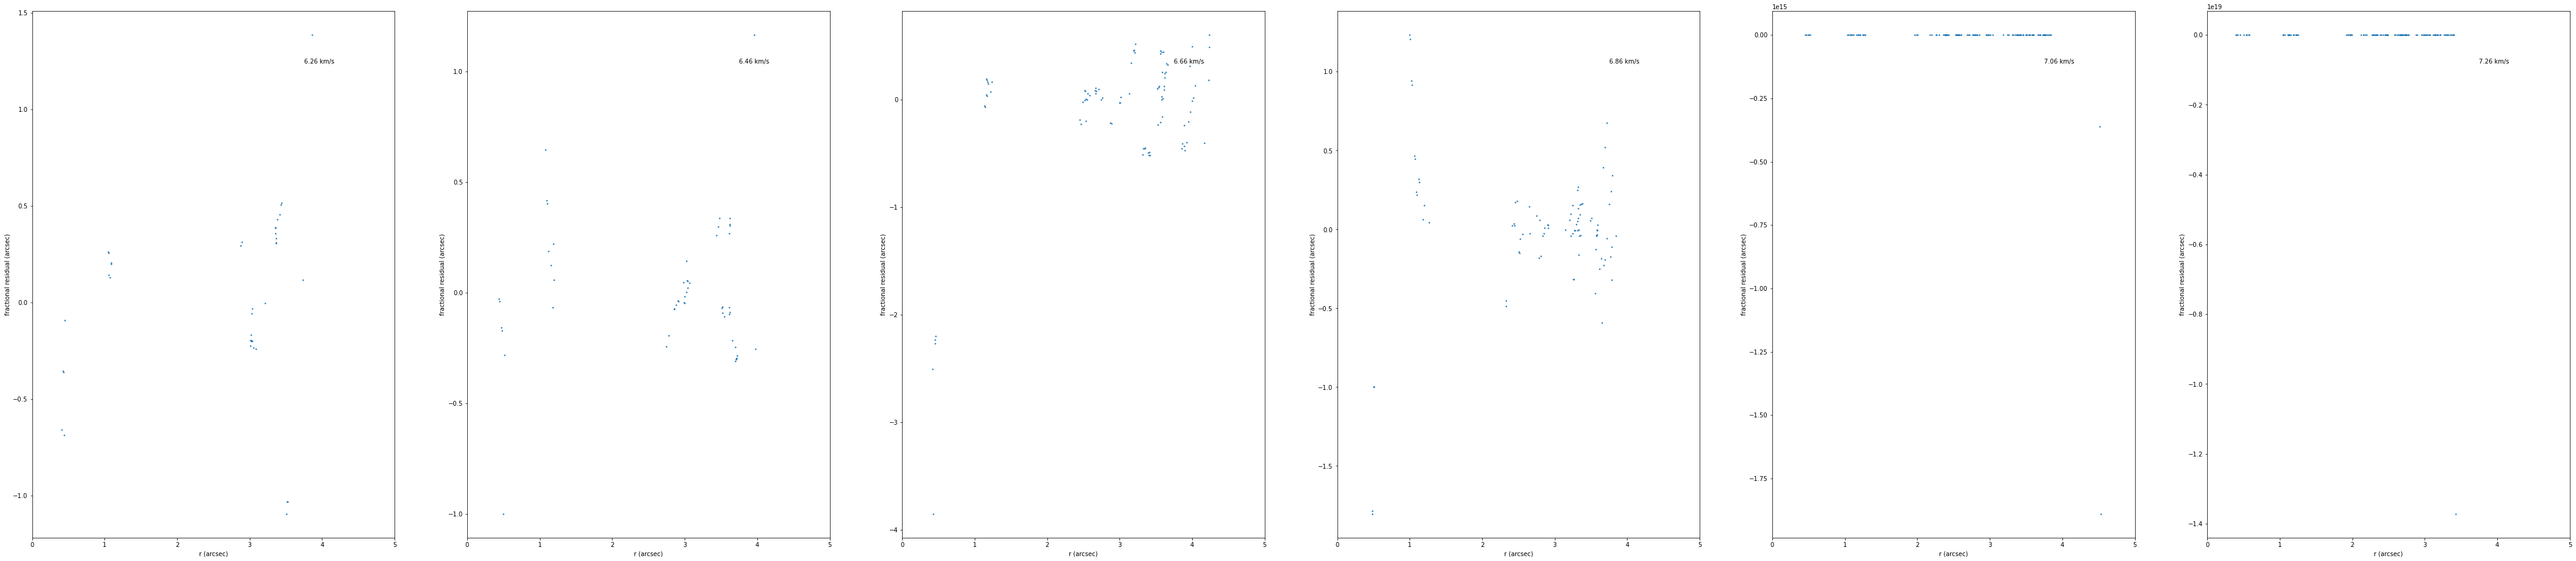

In [74]:
plotting_fractional_residual(path, r, z0, Psi, r_taper, Phi, c_lower, c_upper)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


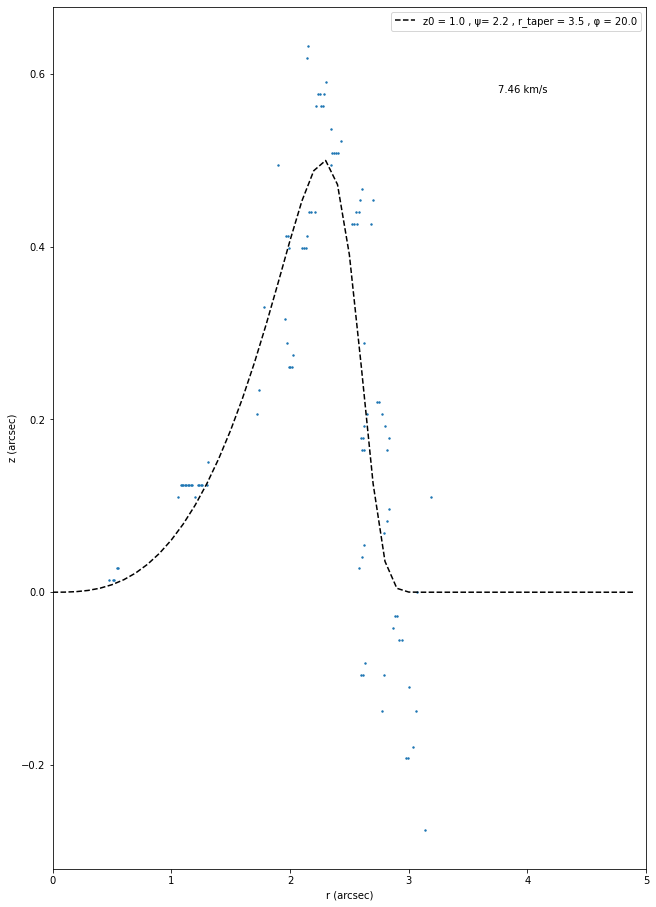

In [7]:
best_fit_curve_and_datapoints(path, r, z0_2, Psi_2, r_taper_2, Phi_2, color_array, c_lower_2, c_upper_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


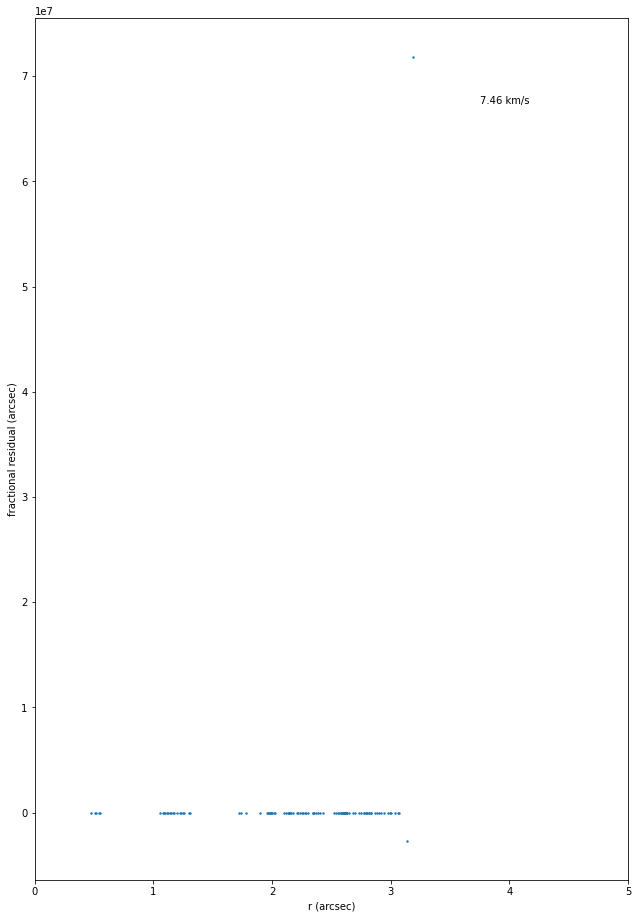

In [75]:
plotting_fractional_residual(path, r, z0_2, Psi_2, r_taper_2, Phi_2, c_lower_2, c_upper_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


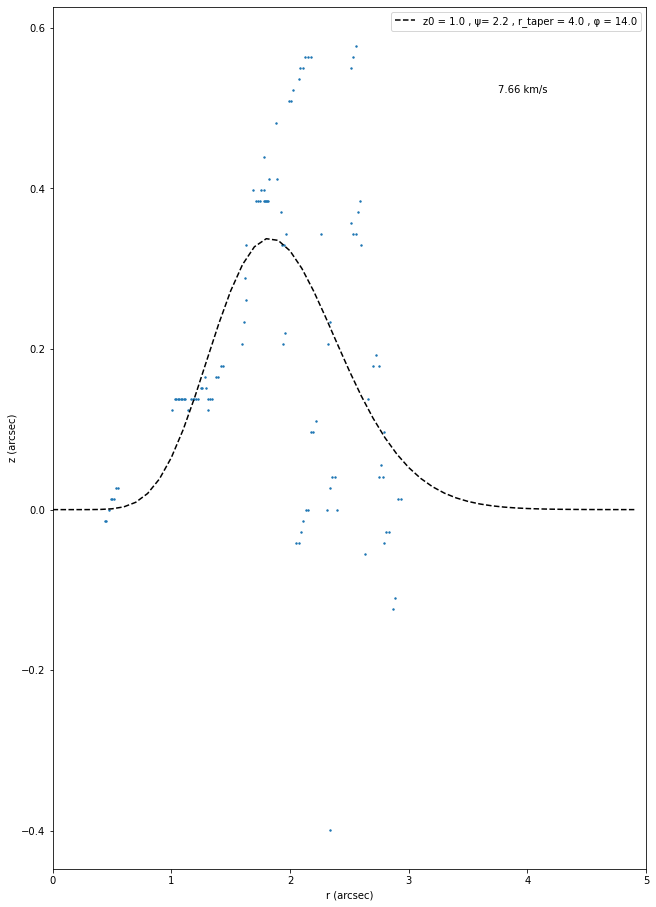

In [23]:
best_fit_curve_and_datapoints(path, r, z0, Psi, r_taper, Phi_3, color_array, c_lower_3, c_upper_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


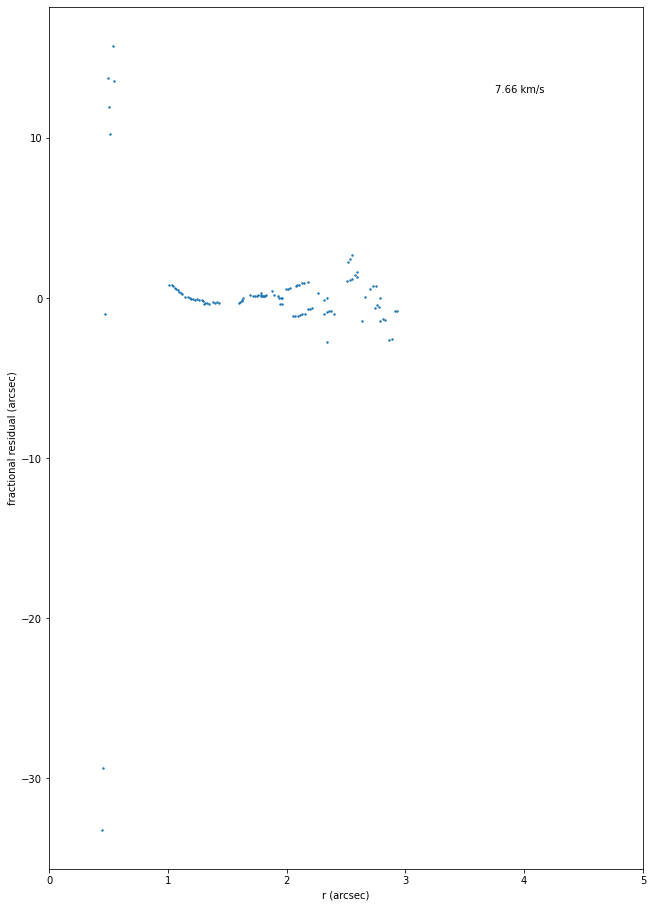

In [76]:
plotting_fractional_residual(path, r, z0, Psi, r_taper, Phi_3, c_lower_3, c_upper_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


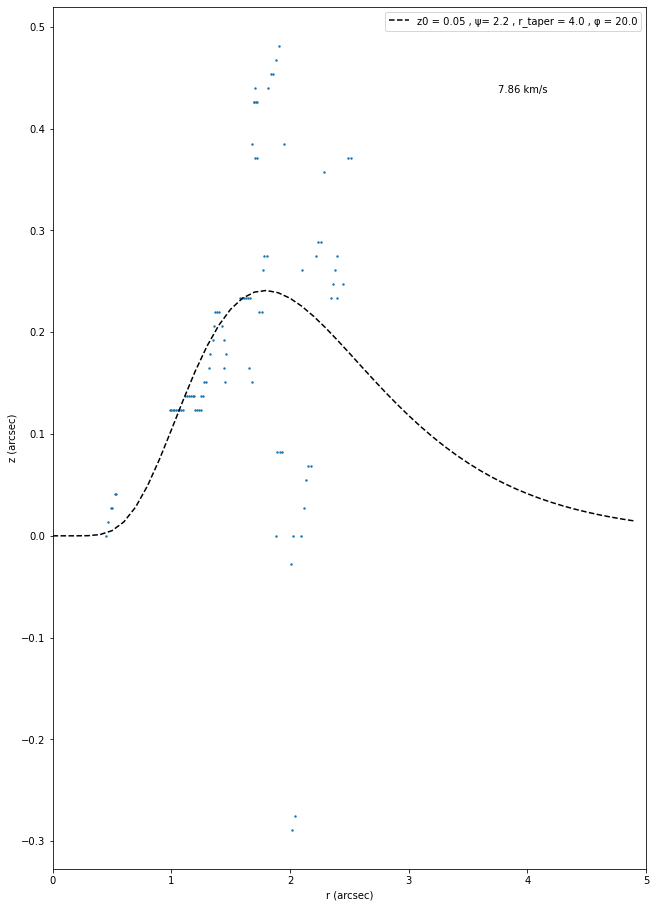

In [25]:
best_fit_curve_and_datapoints(path, r, z0_3, Psi, r_taper, Phi, color_array, c_lower_4, c_upper_4)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


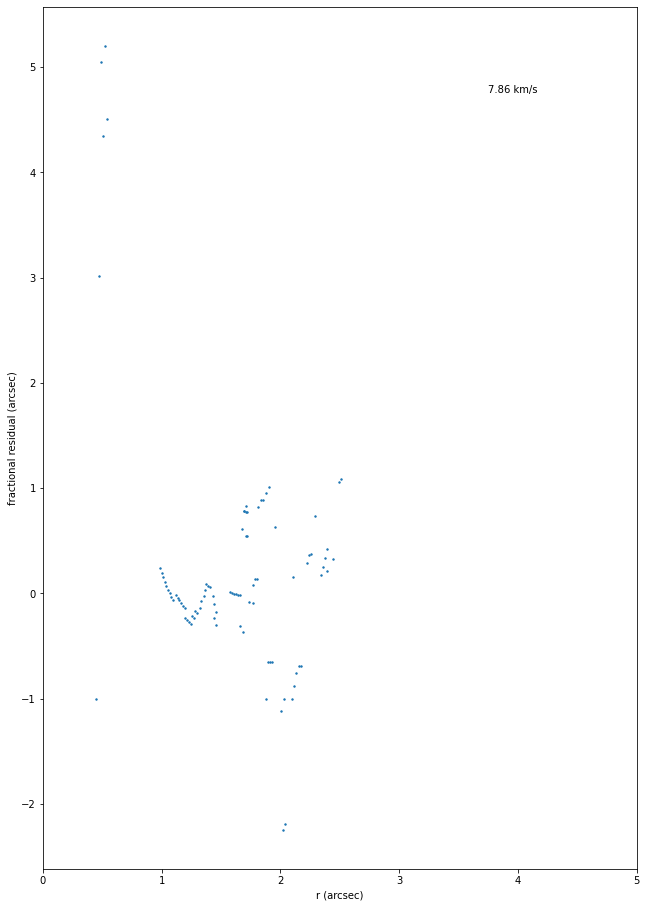

In [77]:
plotting_fractional_residual(path, r, z0_3, Psi, r_taper, Phi, c_lower_4, c_upper_4)

The fractional residuals are better in channel "6.46 km/s", "6.66 km/s", and "6.86 km/s" because there are no generic patterns in these channels and the deviation between the observed values and the real data points are generally smaller than other channels.

Generally speaking, the lager the radii, the bigger the deviation between the observed values and the model predictions.

Fractional residual and best-fit model plots of HD_163296_HCN_260GHz_hf1.0.2arcsec.clean.JvMcorr.image.pbcor.fits :

In [86]:
color_array = ['black', 'grey', 'red', 'peru', 'tan', 'orange', 'olive', 'yellow', 'lawngreen', 'seagreen', 'lightgreen', 'cyan', 'dodgerblue', 'navy', 'violet', 'orchid']
r_2 = np.arange(0, 5, step=0.1)
z0_3 = [0.5]
Psi_3 = [2.1]
r_taper_3 = [3.0]
Phi_3 = [20.0]

z0_4 = [0.5]
Psi_4 = [2.1]
r_taper_4 = [1.8]
Phi_4 = [20.0]

c_lower_5 = 6.26
c_upper_5 = 7.66

c_lower_6 = 7.86
c_upper_6 = 7.86

path_2 = '/data/shared/HD163296_MAPS/HD_163296_HCN_260GHz_hf1.0.2arcsec.clean.JvMcorr.image.pbcor.fits'

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


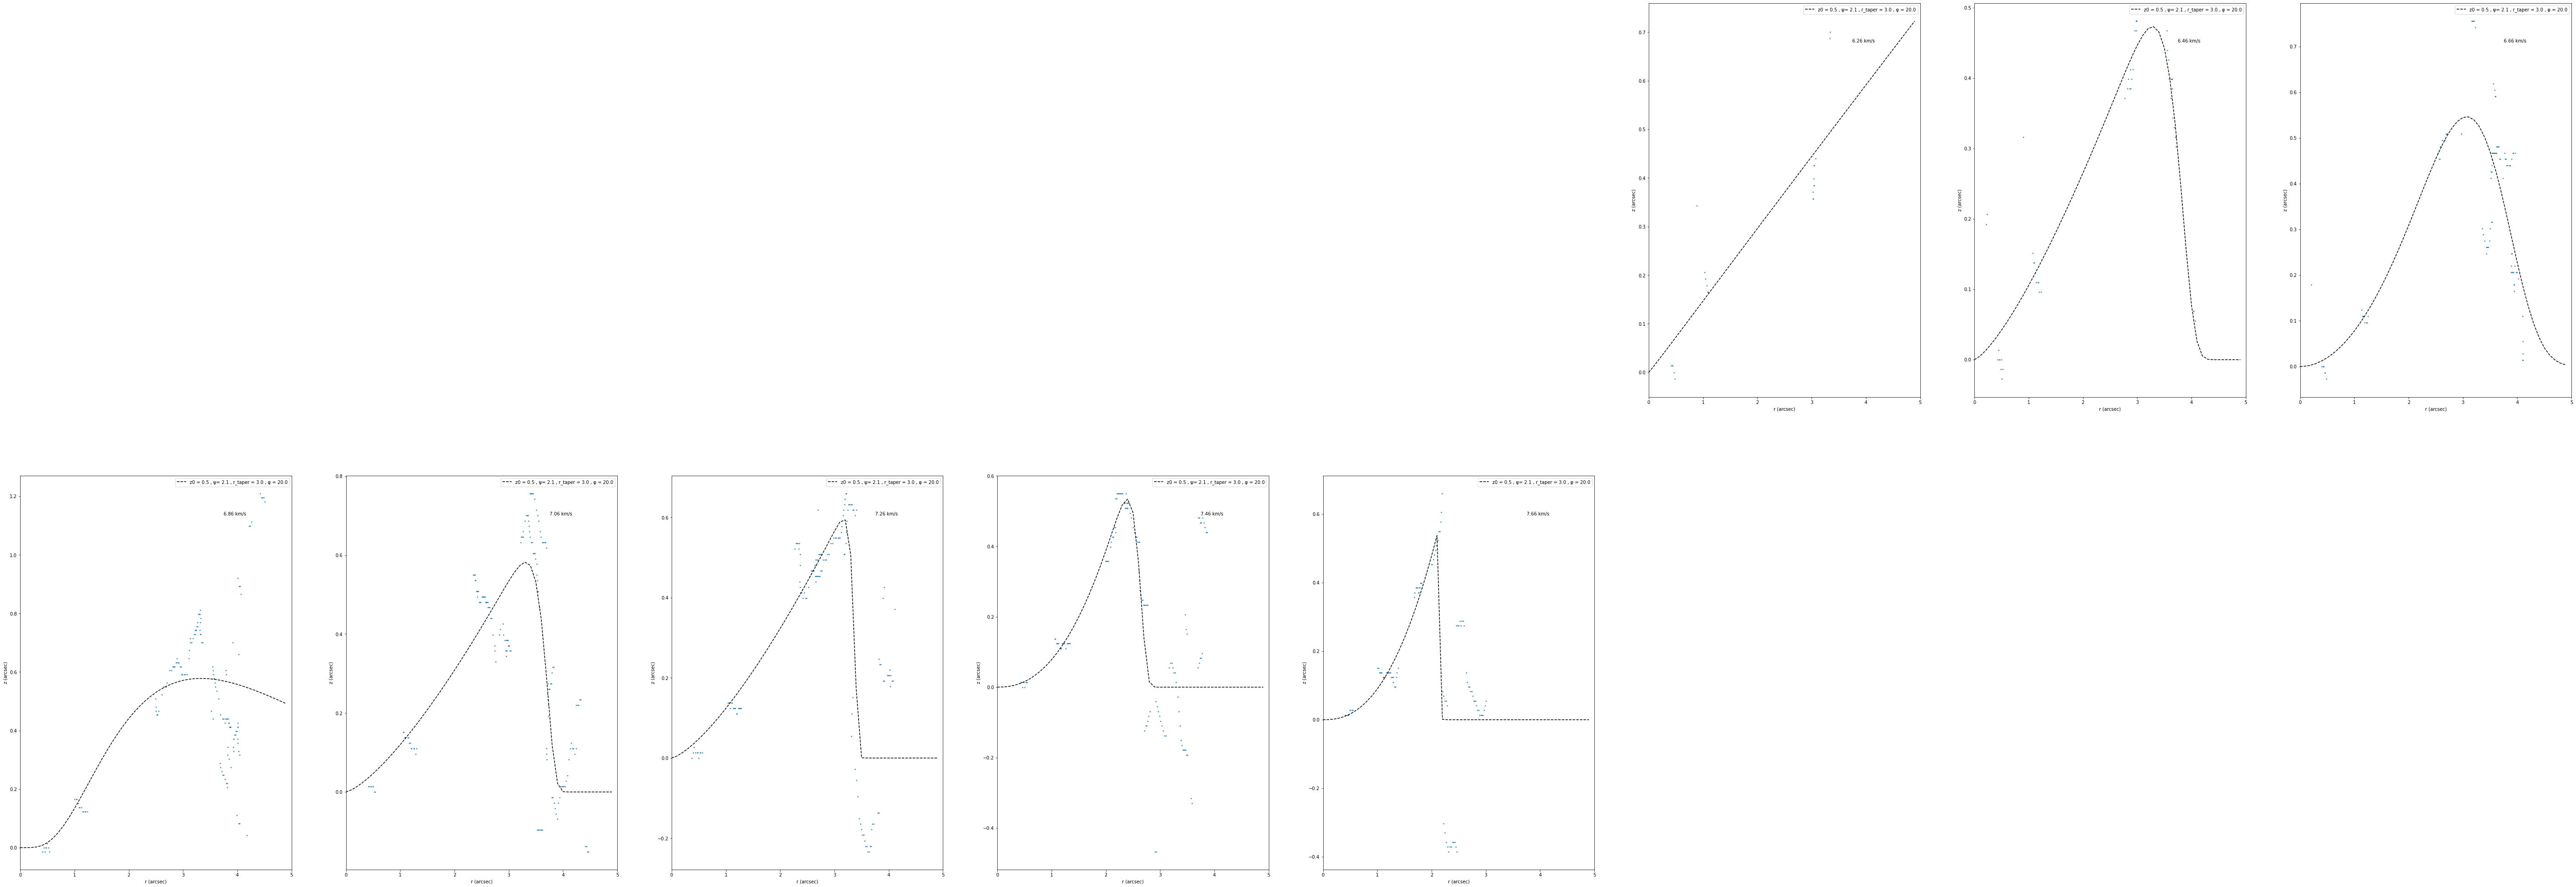

In [83]:
best_fit_curve_and_datapoints(path_2, r_2, z0_3, Psi_3, r_taper_3, Phi_3, color_array, c_lower_5, c_upper_5)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


<ipython-input-2-67fb193d4926>:15: RuntimeWarning: overflow encountered in true_divide
  residual = (z_measured - z_model) / z_model
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


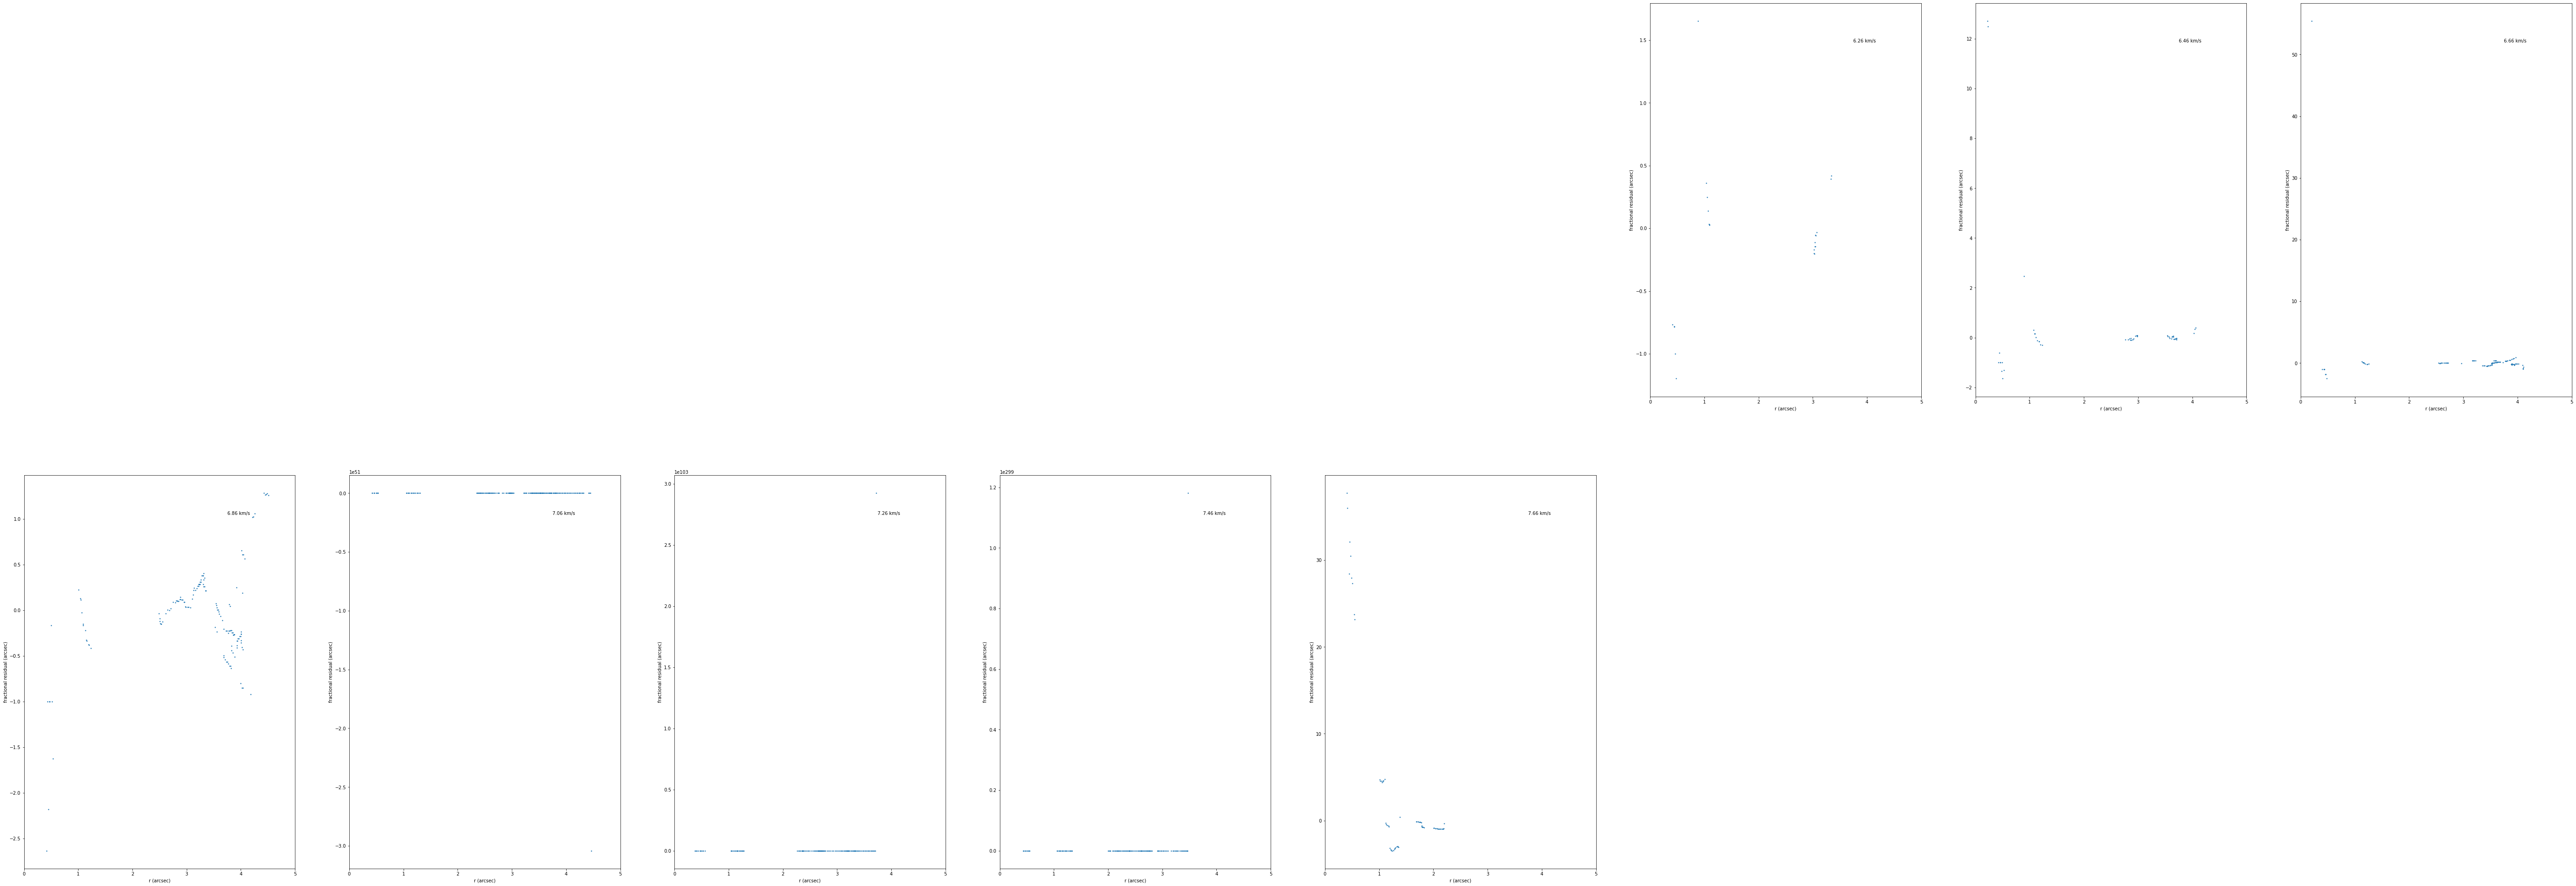

In [89]:
plotting_fractional_residual(path_2, r_2, z0_3, Psi_3, r_taper_3, Phi_3, c_lower_5, c_upper_5)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


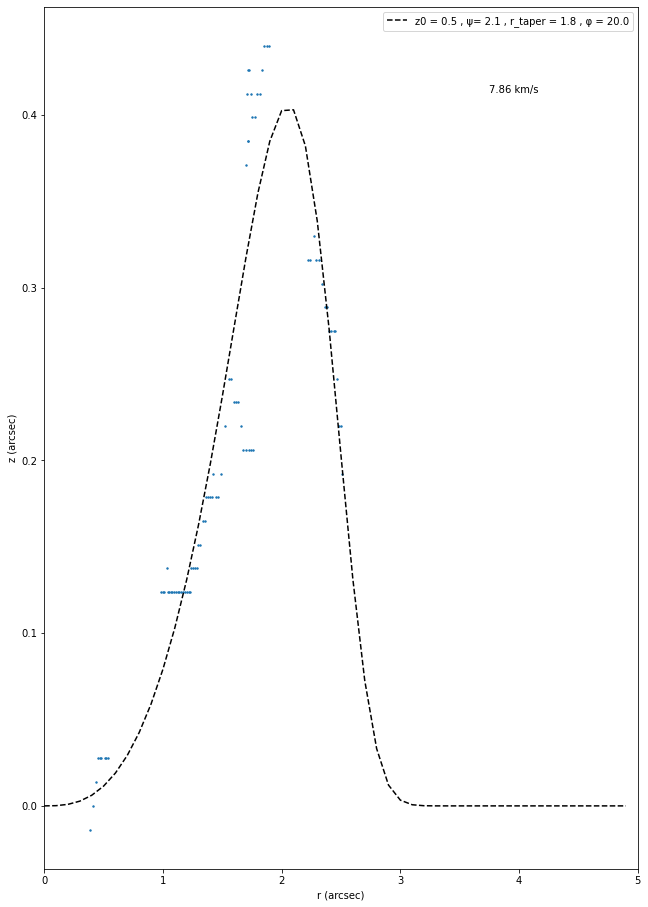

In [87]:
best_fit_curve_and_datapoints(path_2, r_2, z0_4, Psi_4, r_taper_4, Phi_4, color_array, c_lower_6, c_upper_6)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


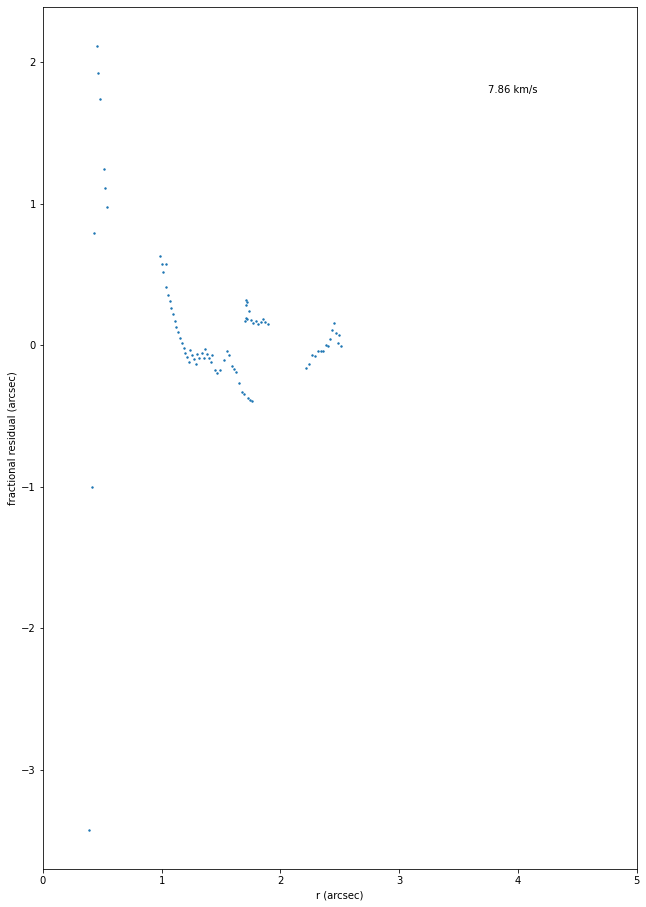

In [88]:
plotting_fractional_residual(path_2, r_2, z0_4, Psi_4, r_taper_4, Phi_4, c_lower_6, c_upper_6)

The fractional residuals are better in channel "6.26 km/s", "6.46 km/s", "6.86 km/s", and "7.66 km/s".

As to how residual changes with the radii, the deviations at larger radii are generally smaller compared to that at smaller radii.

Part II. Restricting the range of the model fits

Function definition:

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation

def best_fit_curve_and_restricted_datapoints(path_in, r_in, z0_in, Psi_in, r_taper_in, Phi_in, r_restricted_in, c_in, color_array_in):
    """
    This function plots best fit curves over restricted datapoints in a given channel.
    It takes in nine parameters.
    
    Args:
        path_in (str): name[no units] of directory holding the real ALMA observational images.
        zo_in (float/list): input scale height [in arcsec].
        r_in (float/list): input list of the radii[in arcsec] we are observing.
        Psi_in (float/list): a unitless parameter.
        r_taper_in (float/list): input "tapered" radius [in arcsec].
        Phi_in (float/list): another unitless parameter.
        r_restricted_in (float): input restricted radius [in arcsec].
        c_in (float): input channel [in km/s].
        color_array_in (list): input list of colors.
        
    Returns:
        This function returns nothing.
    """
    HD163296_molecule = disk_observation(path_in)
    r, z, Fnu, velocity, x, yf, yn = HD163296_molecule.get_emission_surface_v2(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5, min_Fnu = 0.0025)
    fig = plt.figure(figsize=(80, 80))
    i = np.array([])
    for index, velo in enumerate(np.unique(velocity)):
        if round(velo / 1000., 2) == c_in:
            rvals_tofit = r[np.where(velocity==velo)]
            zvals_tofit = z[np.where(velocity==velo)]
            rvals_tofit = rvals_tofit[np.where(r[np.where(velocity==velo)]<r_restricted_in)]
            zvals_tofit = zvals_tofit[np.where(r[np.where(velocity==velo)]<r_restricted_in)]
            i = 0
            ax = plt.subplot(7, 8, index+1)
            ax.scatter(rvals_tofit, zvals_tofit,s=2)
            ax.set_xlabel('r (arcsec)')
            ax.set_ylabel('z (arcsec)')
            ax.set_xlim(left = 0, right=4)
            ax.text(0.75, 0.9, "%.2f km/s" % (velo/1000.), transform=ax.transAxes)
            for count, value in enumerate(product(z0_in, Psi_in, r_taper_in, Phi_in)):
                popt, cov = HD163296_molecule.fit_emission_surface(rvals_tofit, zvals_tofit, curve_fit_kwargs = {'p0': np.array([value[0], value[1], value[2], value[3]])})
                ax.plot(r_in, tapered_power_law(r_in, popt[0], popt[1], popt[2], popt[3]), 'r--', color=color_array_in[i], label='z0 = ' + str(value[0]) + ' , ψ= ' + str(value[1]) + ' , r_taper = ' + str(value[2]) + ' , φ = ' + str(value[3]))
                i = i + 1
                ax.legend()
    plt.show()

In [118]:
c = [6.26, 7.06, 7.26]
c_2 = [7.46]
c_3 = [7.66]
c_4 = [7.86]
c_5 = [7.06, 7.26, 7.46, 7.66]

r_3 = [np.arange(0, 3.4, step=0.1), np.arange(0, 3.3, step=0.1), np.arange(0, 2.8, step=0.1)]
r_4 = np.arange(0, 2.5, step=0.1)
r_5 = np.arange(0, 1.9, step=0.1)
r_6 = np.arange(0, 1.9, step=0.1)
r_7 = [np.arange(0, 3.4, step=0.1), np.arange(0, 3.1, step=0.1), np.arange(0, 2.5, step=0.1), np.arange(0, 2.1, step=0.1)]

r_restricted = [3.4, 3.3, 2.8]
r_restricted_2 = [2.5]
r_restricted_3 = [1.9]
r_restricted_4 = [1.9]
r_restricted_5 = [3.4, 3.1, 2.5, 2.1]

Restricted best-fit model plots of HD_163296_HCN_260GHz_hf1.robust_0.5.clean.JvMcorr.image.pbcor.fits :

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


<ipython-input-3-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


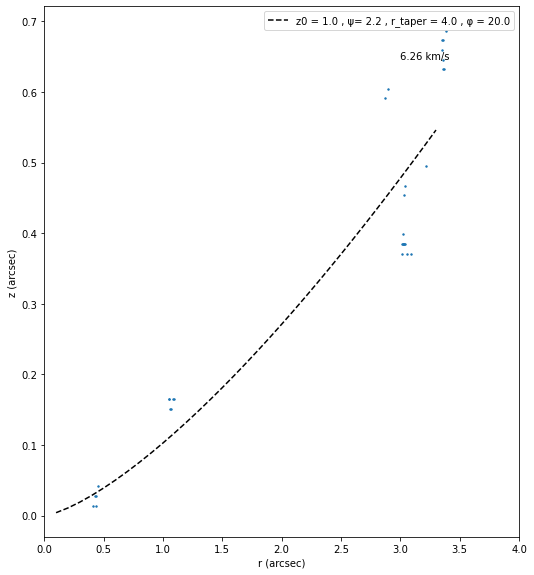

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


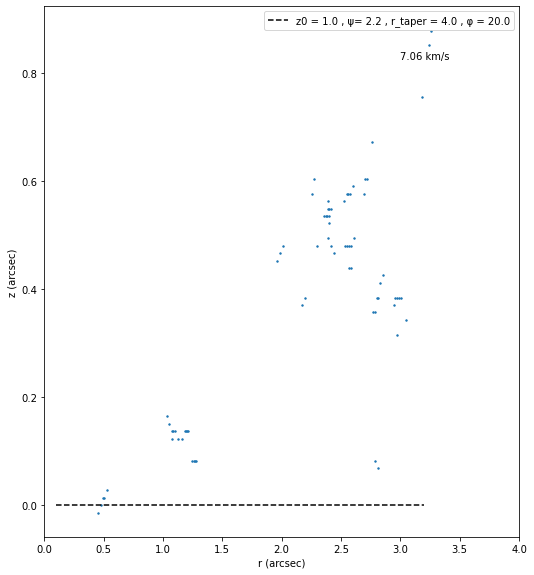

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in

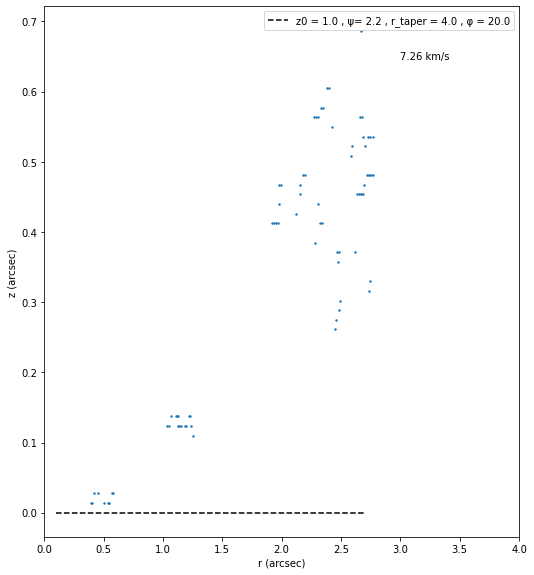

In [113]:
for count, value in enumerate(c):
    best_fit_curve_and_restricted_datapoints(path, r_3[count], z0, Psi, r_taper, Phi, r_restricted[count], c[count], color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


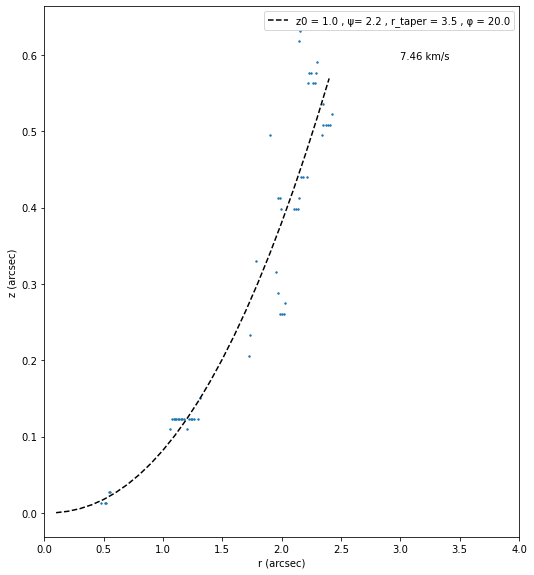

In [112]:
best_fit_curve_and_restricted_datapoints(path, r_4, z0_2, Psi_2, r_taper_2, Phi_2, r_restricted_2, c_2, color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


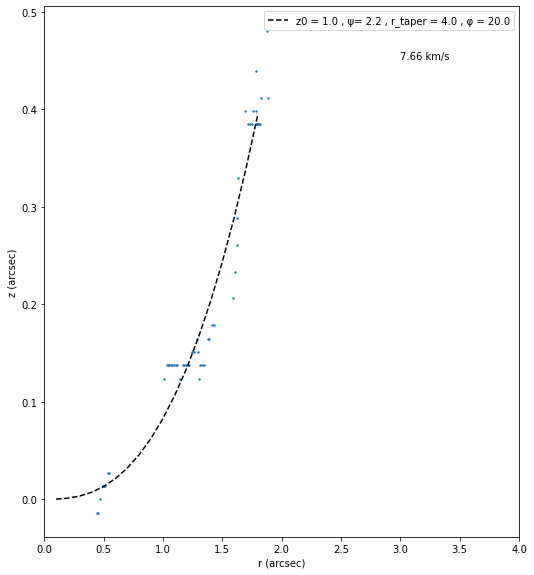

In [114]:
best_fit_curve_and_restricted_datapoints(path, r_5, z0, Psi, r_taper, Phi_3, r_restricted_3, c_3, color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


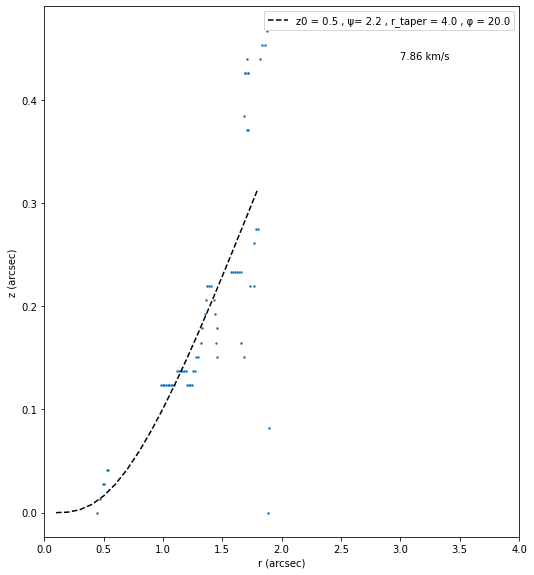

In [115]:
best_fit_curve_and_restricted_datapoints(path, r_6, z0_3, Psi, r_taper, Phi, r_restricted_4, c_4, color_array)

Restricted best-fit model plots of HD_163296_HCN_260GHz_hf1.0.2arcsec.clean.JvMcorr.image.pbcor.fits :

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


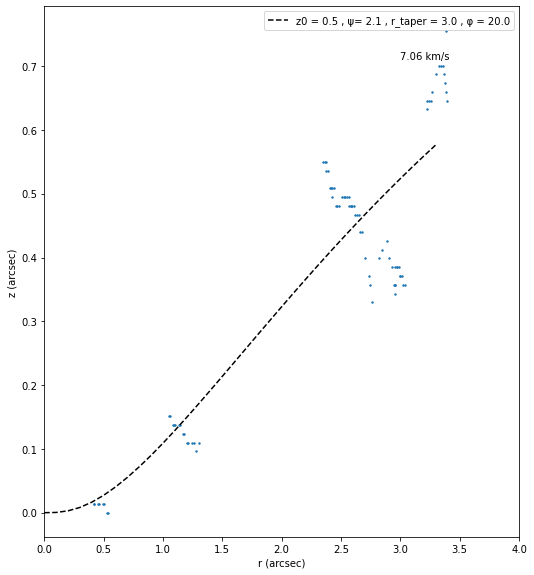

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


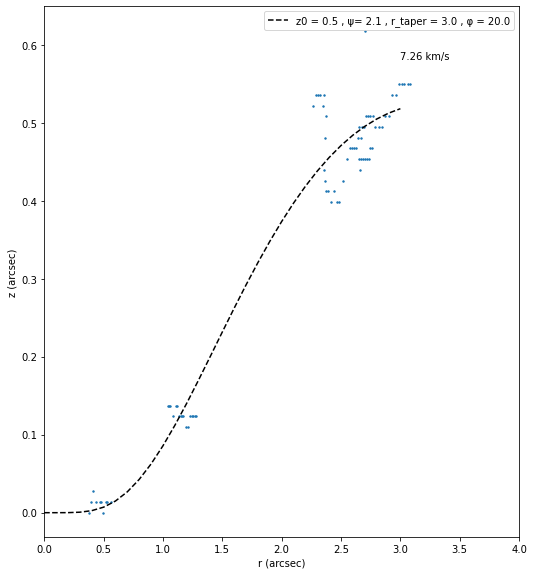

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


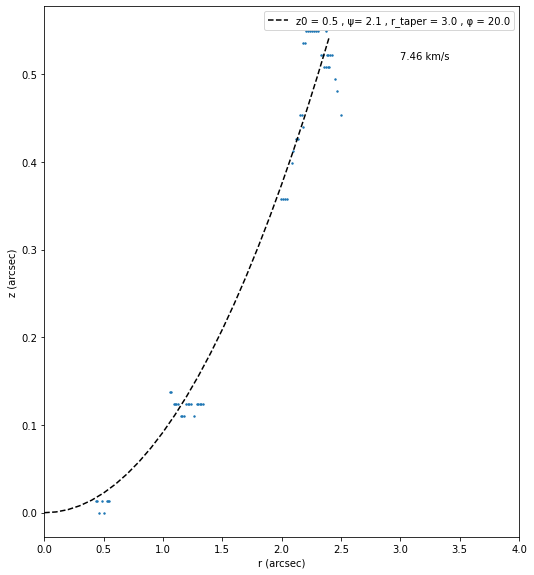

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-3-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in

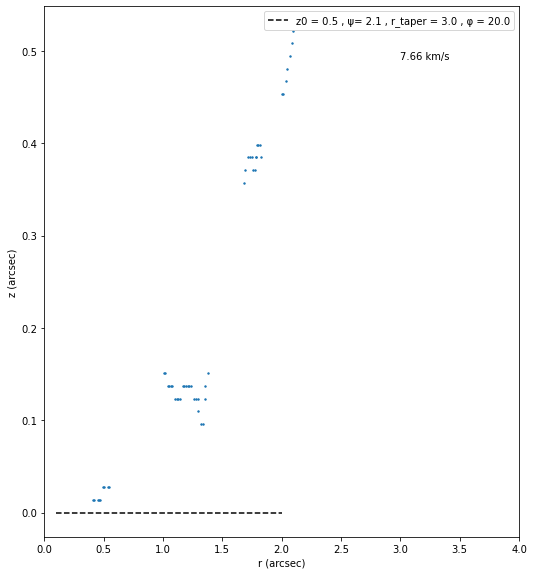

In [121]:
for count, value in enumerate(c_5):
    best_fit_curve_and_restricted_datapoints(path_2, r_7[count], z0_3, Psi_3, r_taper_3, Phi_3, r_restricted_5[count], c_5[count], color_array)

Part III. Modeling other lines

In [35]:
z0_c18o = [0.05]
Psi_c18o = [2.2]
r_taper_c18o = [3.5]
Phi_c18o = [14.0]

z0_co = [1.0]
Psi_co = [2.2]
r_taper_co = [4.0]
Phi_co = [20.0]

z0_13co = [0.5]
Psi_13co = [2.1]
r_taper_13co = [3.0]
Phi_13co = [20.0]

z0_13co_2 = [0.5]
Psi_13co_2 = [2.1]
r_taper_13co_2 = [1.8]
Phi_13co_2 = [20.0]

z0_co_2 = [0.05]
r_taper_co_2 = [3.5]
Phi_co_2 = [14.0]

c_lower_co = 6.26
c_upper_co = 7.66

c_lower_co_2 = 7.86
c_upper_co_2 = 7.86

c_lower_13co = 6.26
c_upper_13co = 7.86

c_lower_c18o = 6.26
c_upper_c18o = 7.86

path_3 = '/data/shared/HD163296_MAPS/HD_163296_CO_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits'
path_4 = '/data/shared/HD163296_MAPS/HD_163296_CO_220GHz.0.2arcsec.clean.JvMcorr.image.pbcor.fits'
path_5 = '/data/shared/HD163296_MAPS/HD_163296_13CO_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits'
path_6 = '/data/shared/HD163296_MAPS/HD_163296_13CO_220GHz.0.2arcsec.clean.JvMcorr.image.pbcor.fits'
path_7 = '/data/shared/HD163296_MAPS/HD_163296_C18O_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits'
path_8 = '/data/shared/HD163296_MAPS/HD_163296_C18O_220GHz.0.2arcsec.clean.JvMcorr.image.pbcor.fits'

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


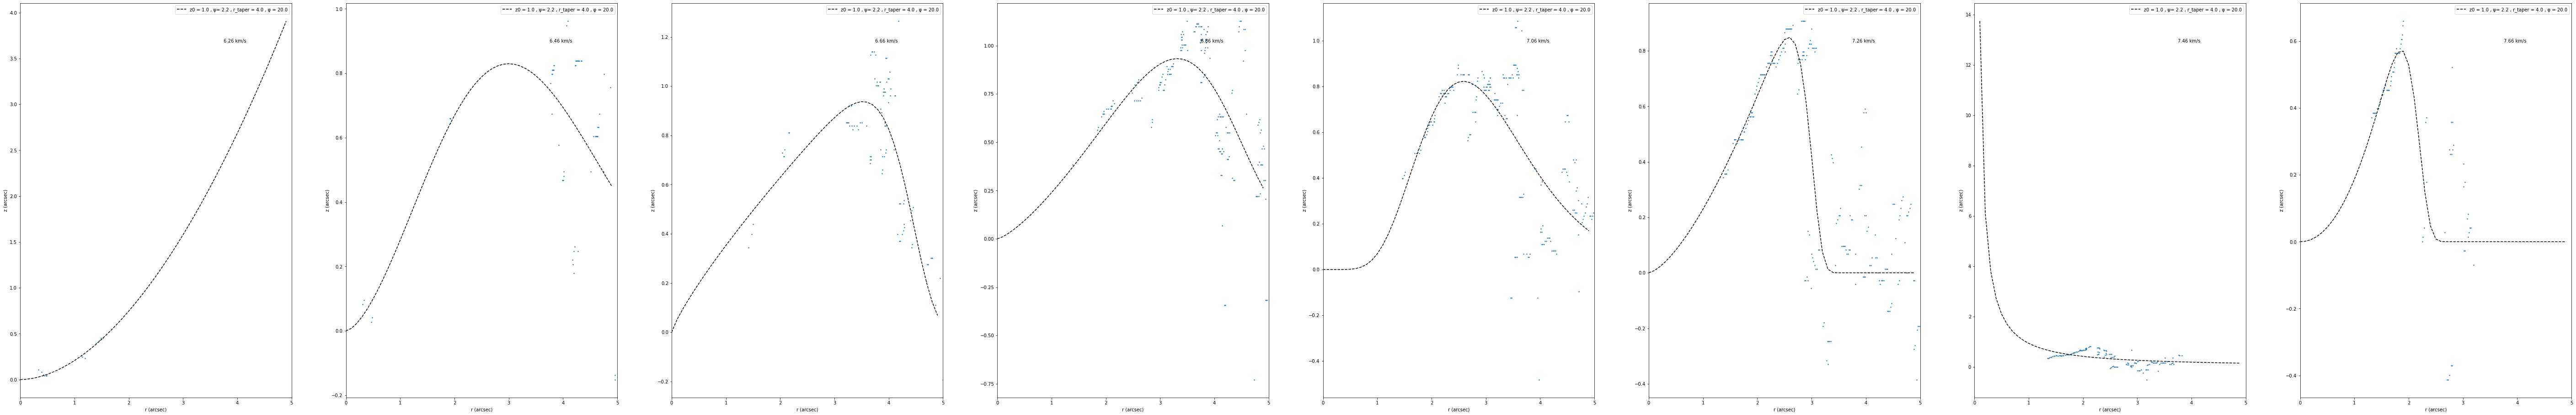

In [9]:
best_fit_curve_and_datapoints(path_3, r, z0_co, Psi_co, r_taper_co, Phi_co, color_array, c_lower_co, c_upper_co)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


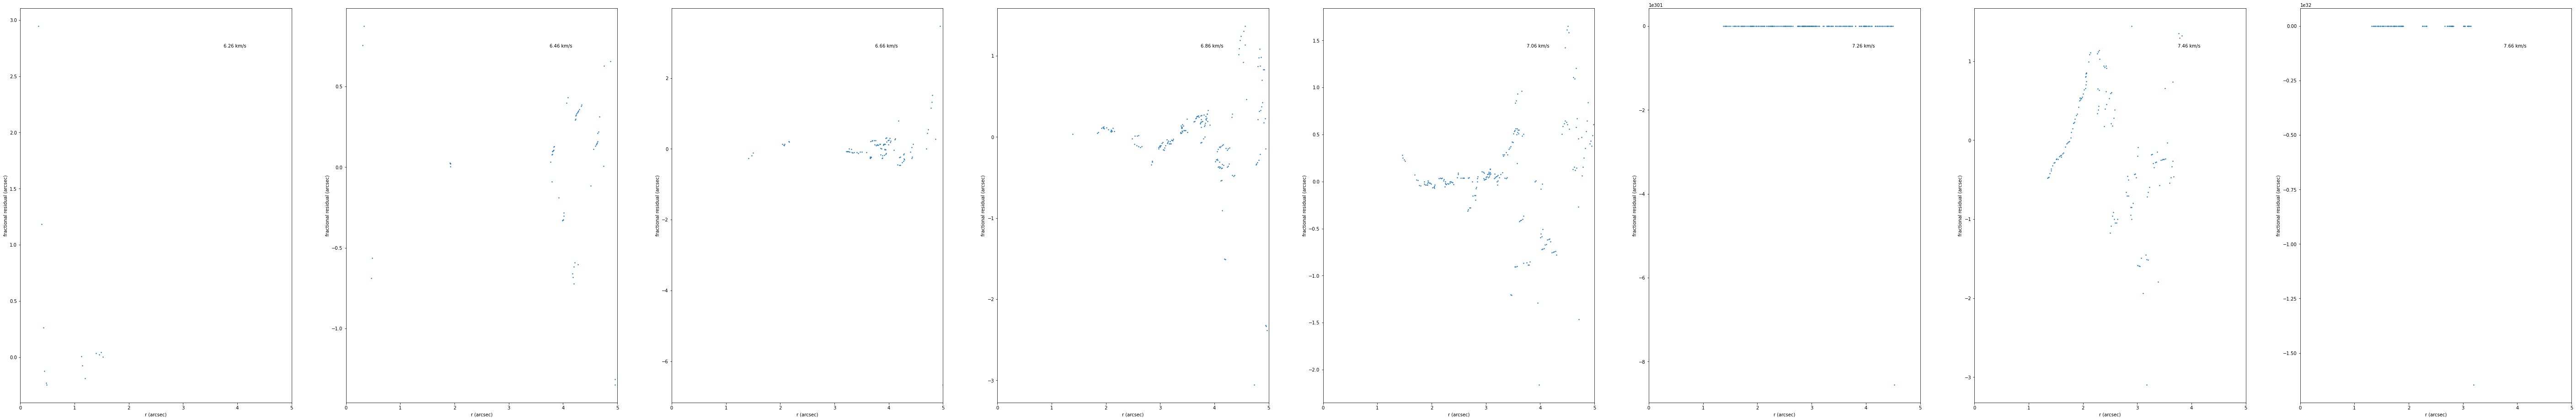

In [141]:
plotting_fractional_residual(path_3, r, z0_co, Psi_co, r_taper_co, Phi_co, c_lower_co, c_upper_co)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


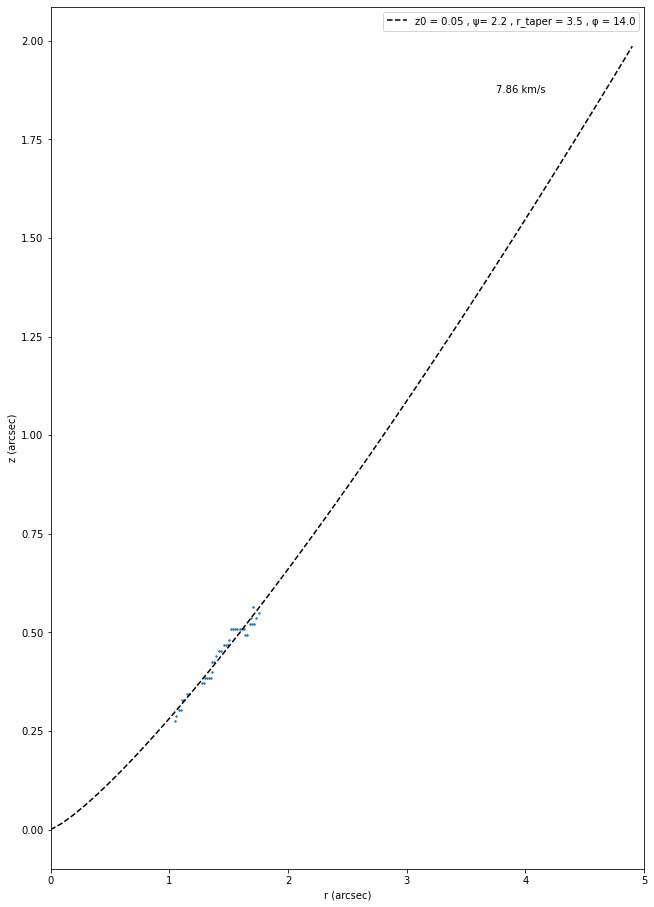

In [11]:
best_fit_curve_and_datapoints(path_3, r, z0_co_2, Psi_co, r_taper_co_2, Phi_co_2, color_array, c_lower_co_2, c_upper_co_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


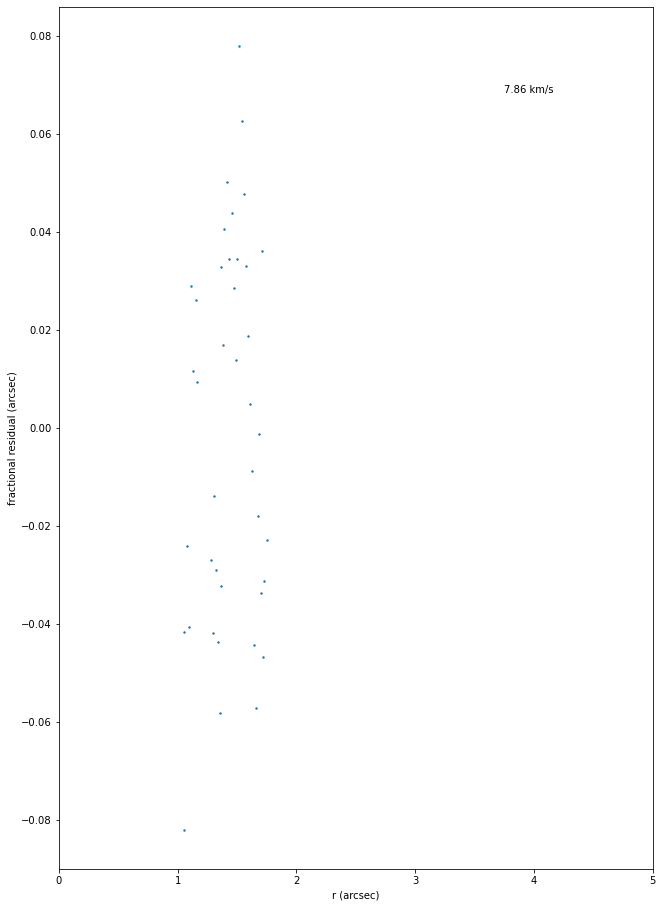

In [12]:
plotting_fractional_residual(path_3, r, z0_co_2, Psi_co, r_taper_co_2, Phi_co_2, c_lower_co_2, c_upper_co_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d0498

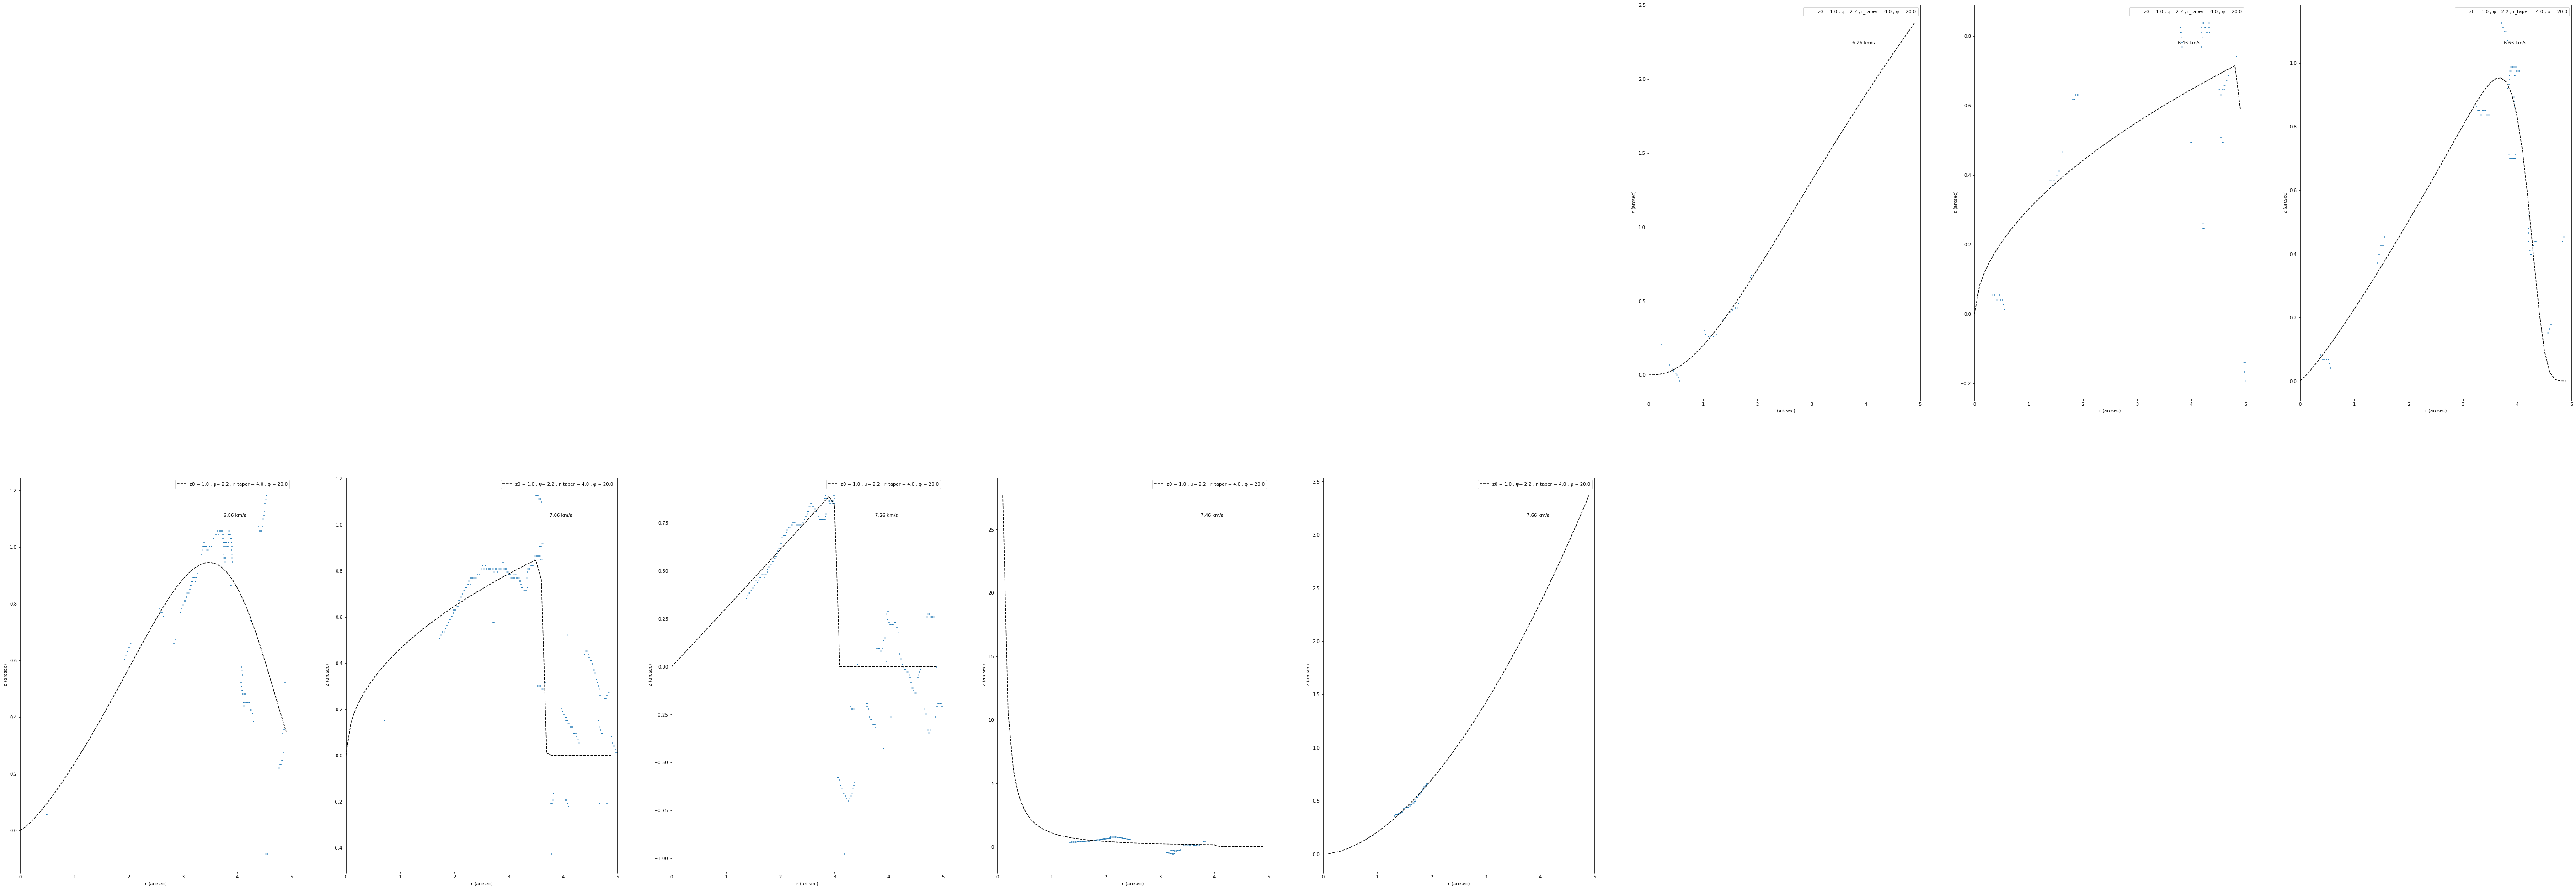

In [14]:
best_fit_curve_and_datapoints(path_4, r, z0_co, Psi_co, r_taper_co, Phi_co, color_array, c_lower_co, c_upper_co)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


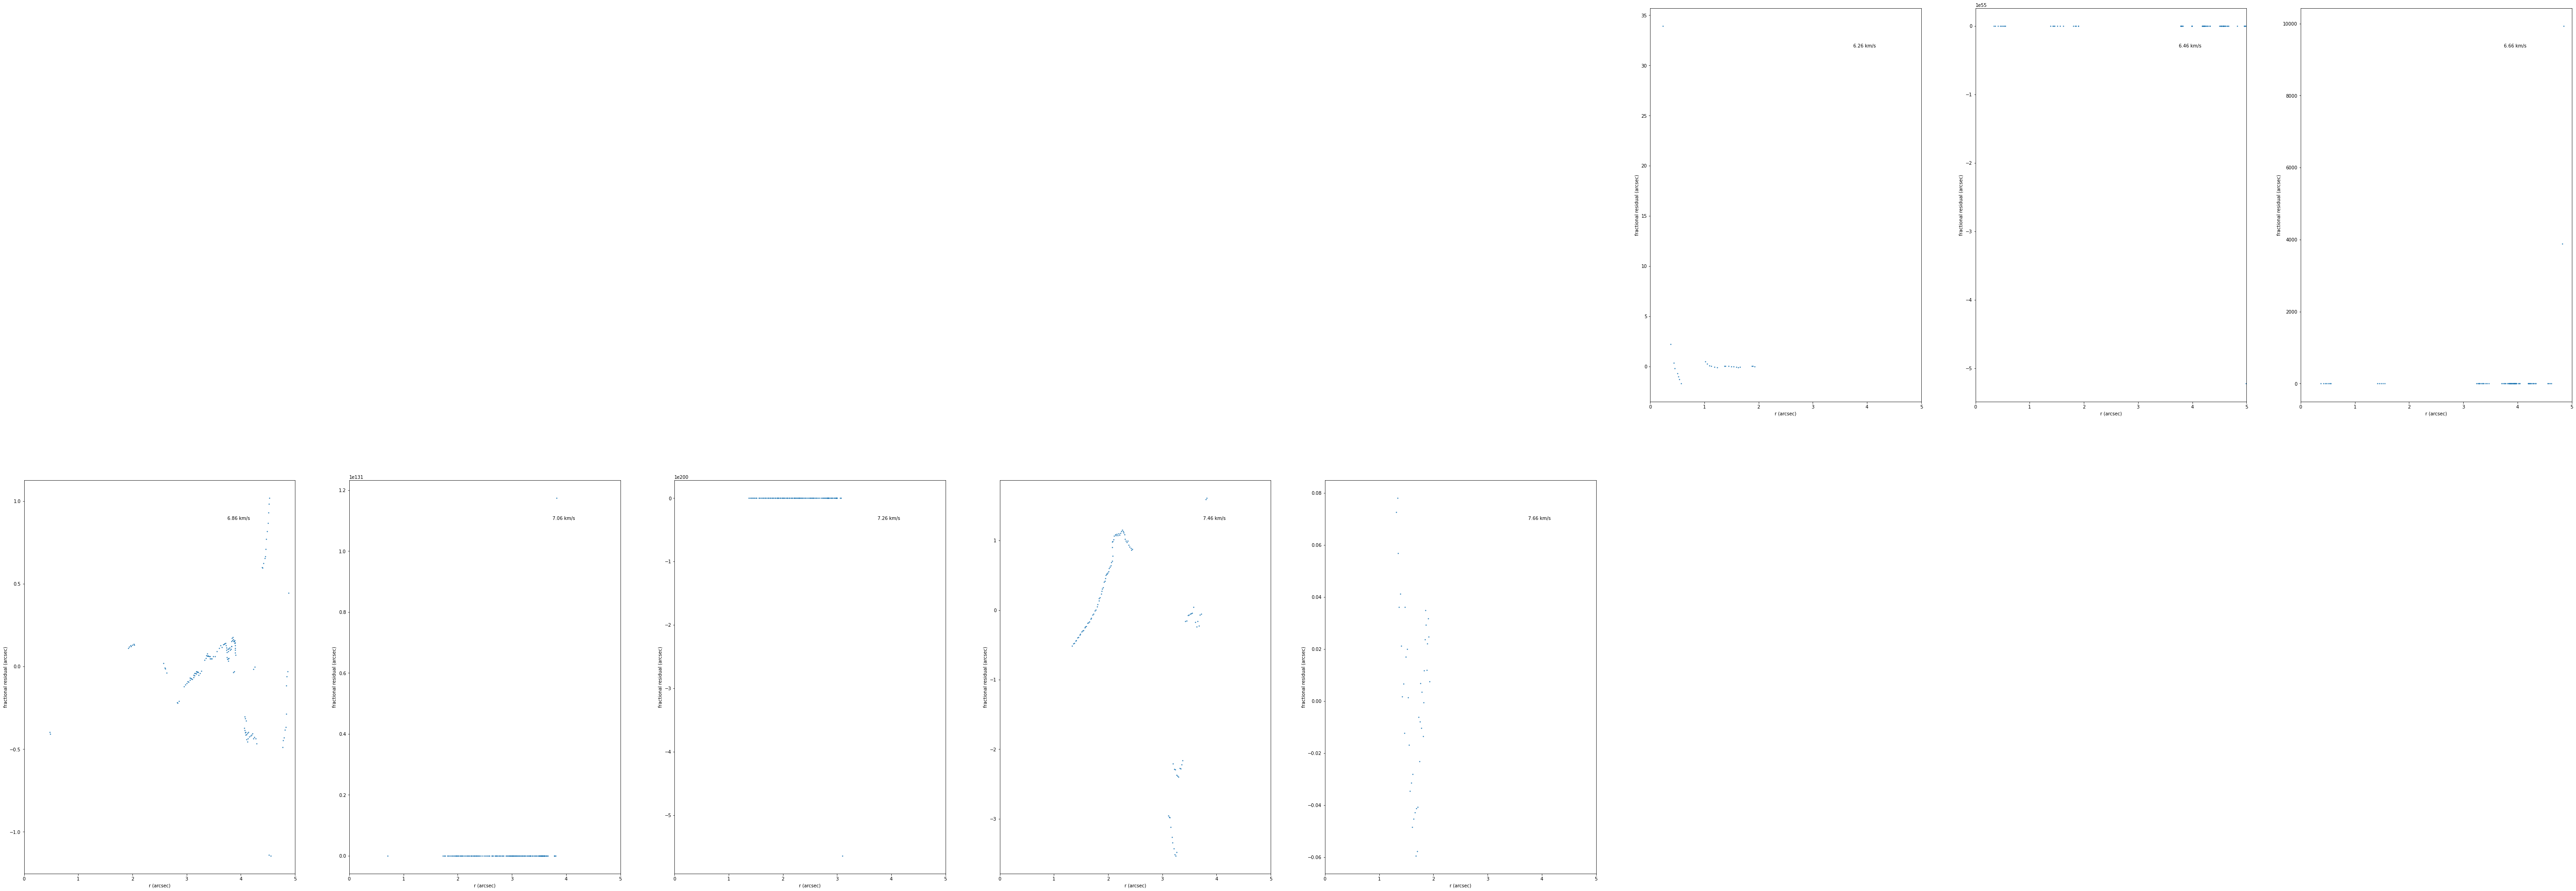

In [16]:
plotting_fractional_residual(path_4, r, z0_co, Psi_co, r_taper_co, Phi_co, c_lower_co, c_upper_co)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


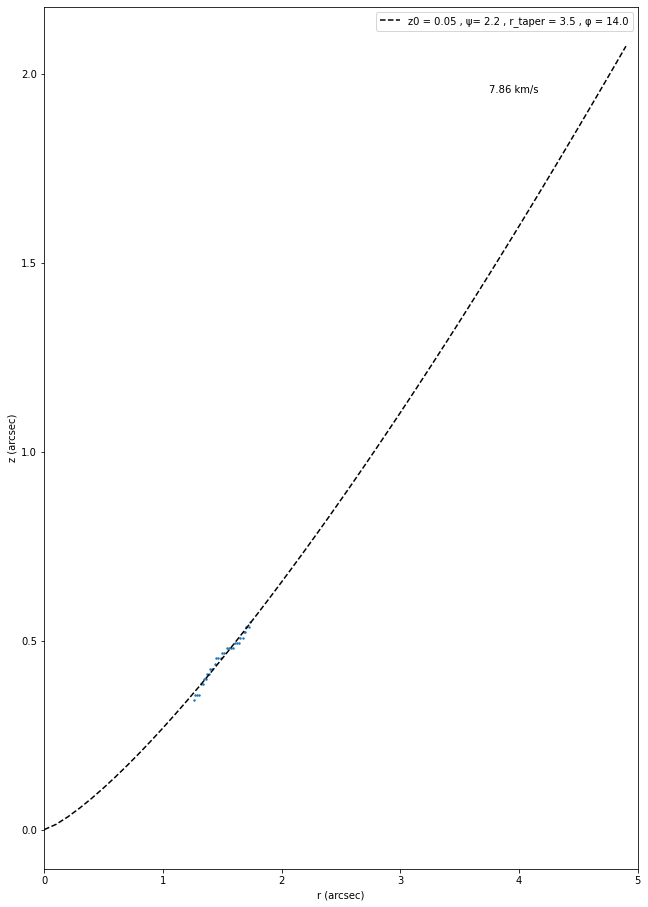

In [15]:
best_fit_curve_and_datapoints(path_4, r, z0_co_2, Psi_co, r_taper_co_2, Phi_co_2, color_array, c_lower_co_2, c_upper_co_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


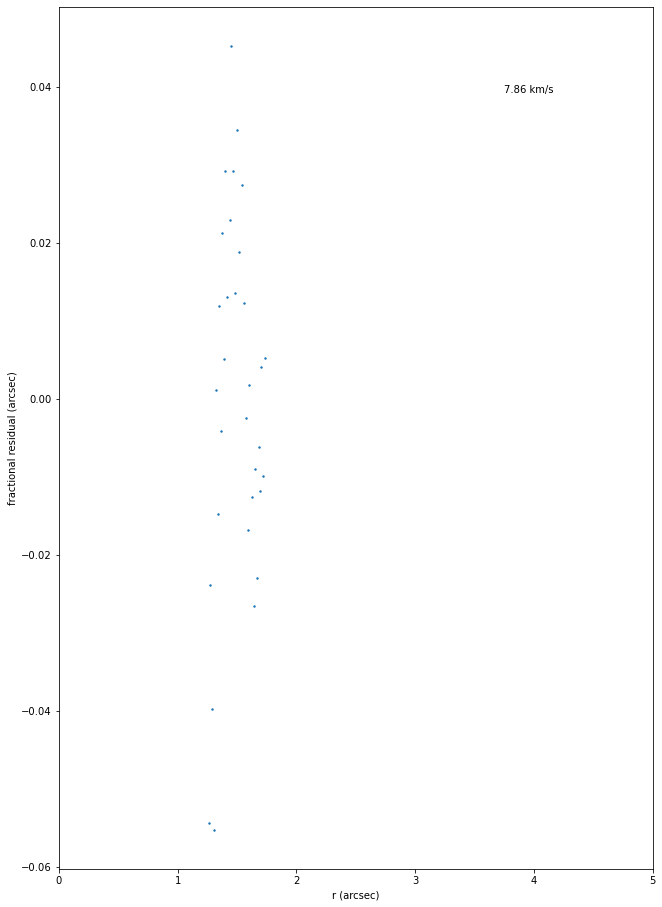

In [17]:
plotting_fractional_residual(path_4, r, z0_co_2, Psi_co, r_taper_co_2, Phi_co_2, c_lower_co_2, c_upper_co_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


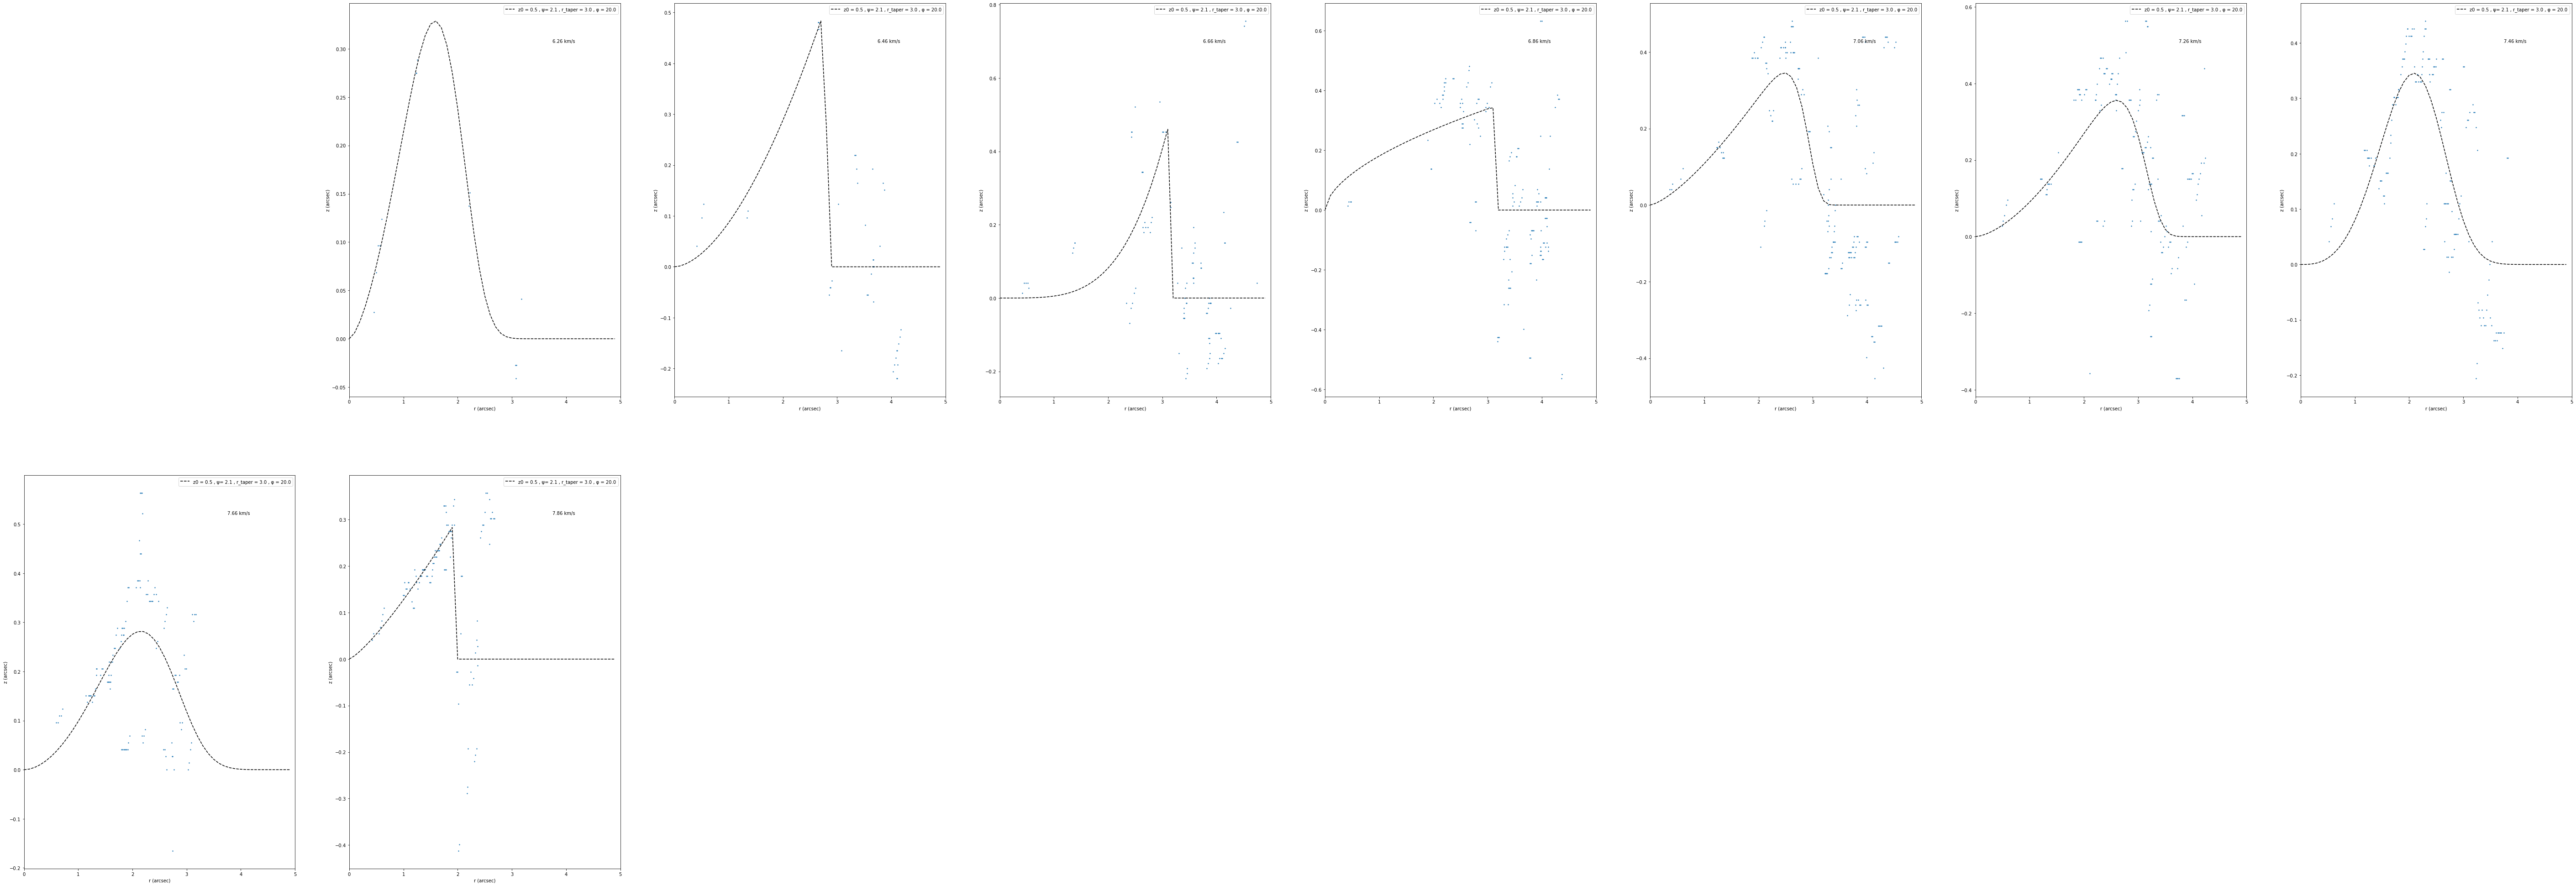

In [21]:
best_fit_curve_and_datapoints(path_5, r, z0_13co, Psi_13co, r_taper_13co, Phi_13co, color_array, c_lower_13co, c_upper_13co)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


<ipython-input-1-4ba3db3a5e3c>:15: RuntimeWarning: overflow encountered in true_divide
  residual = (z_measured - z_model) / z_model


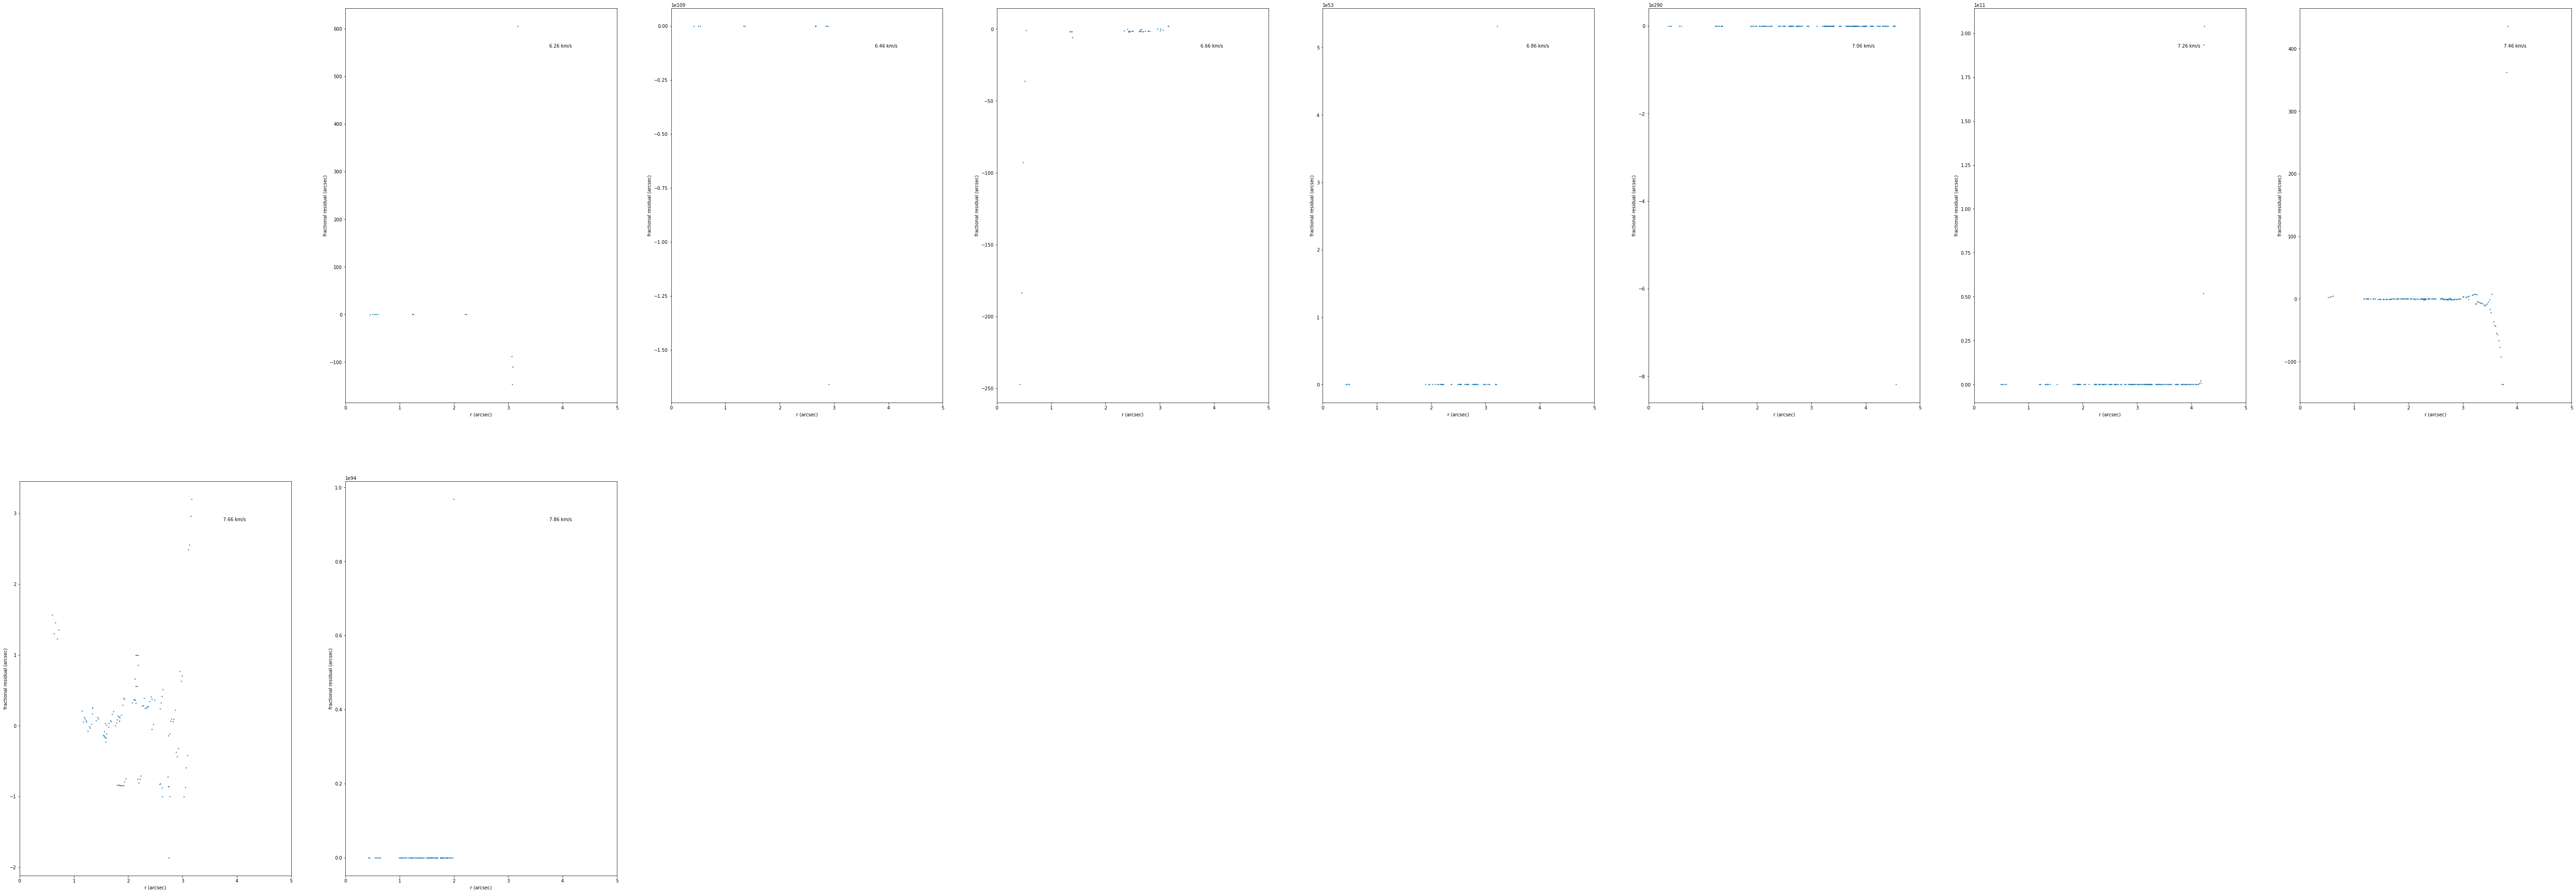

In [22]:
plotting_fractional_residual(path_5, r, z0_13co, Psi_13co, r_taper_13co, Phi_13co, c_lower_13co, c_upper_13co)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


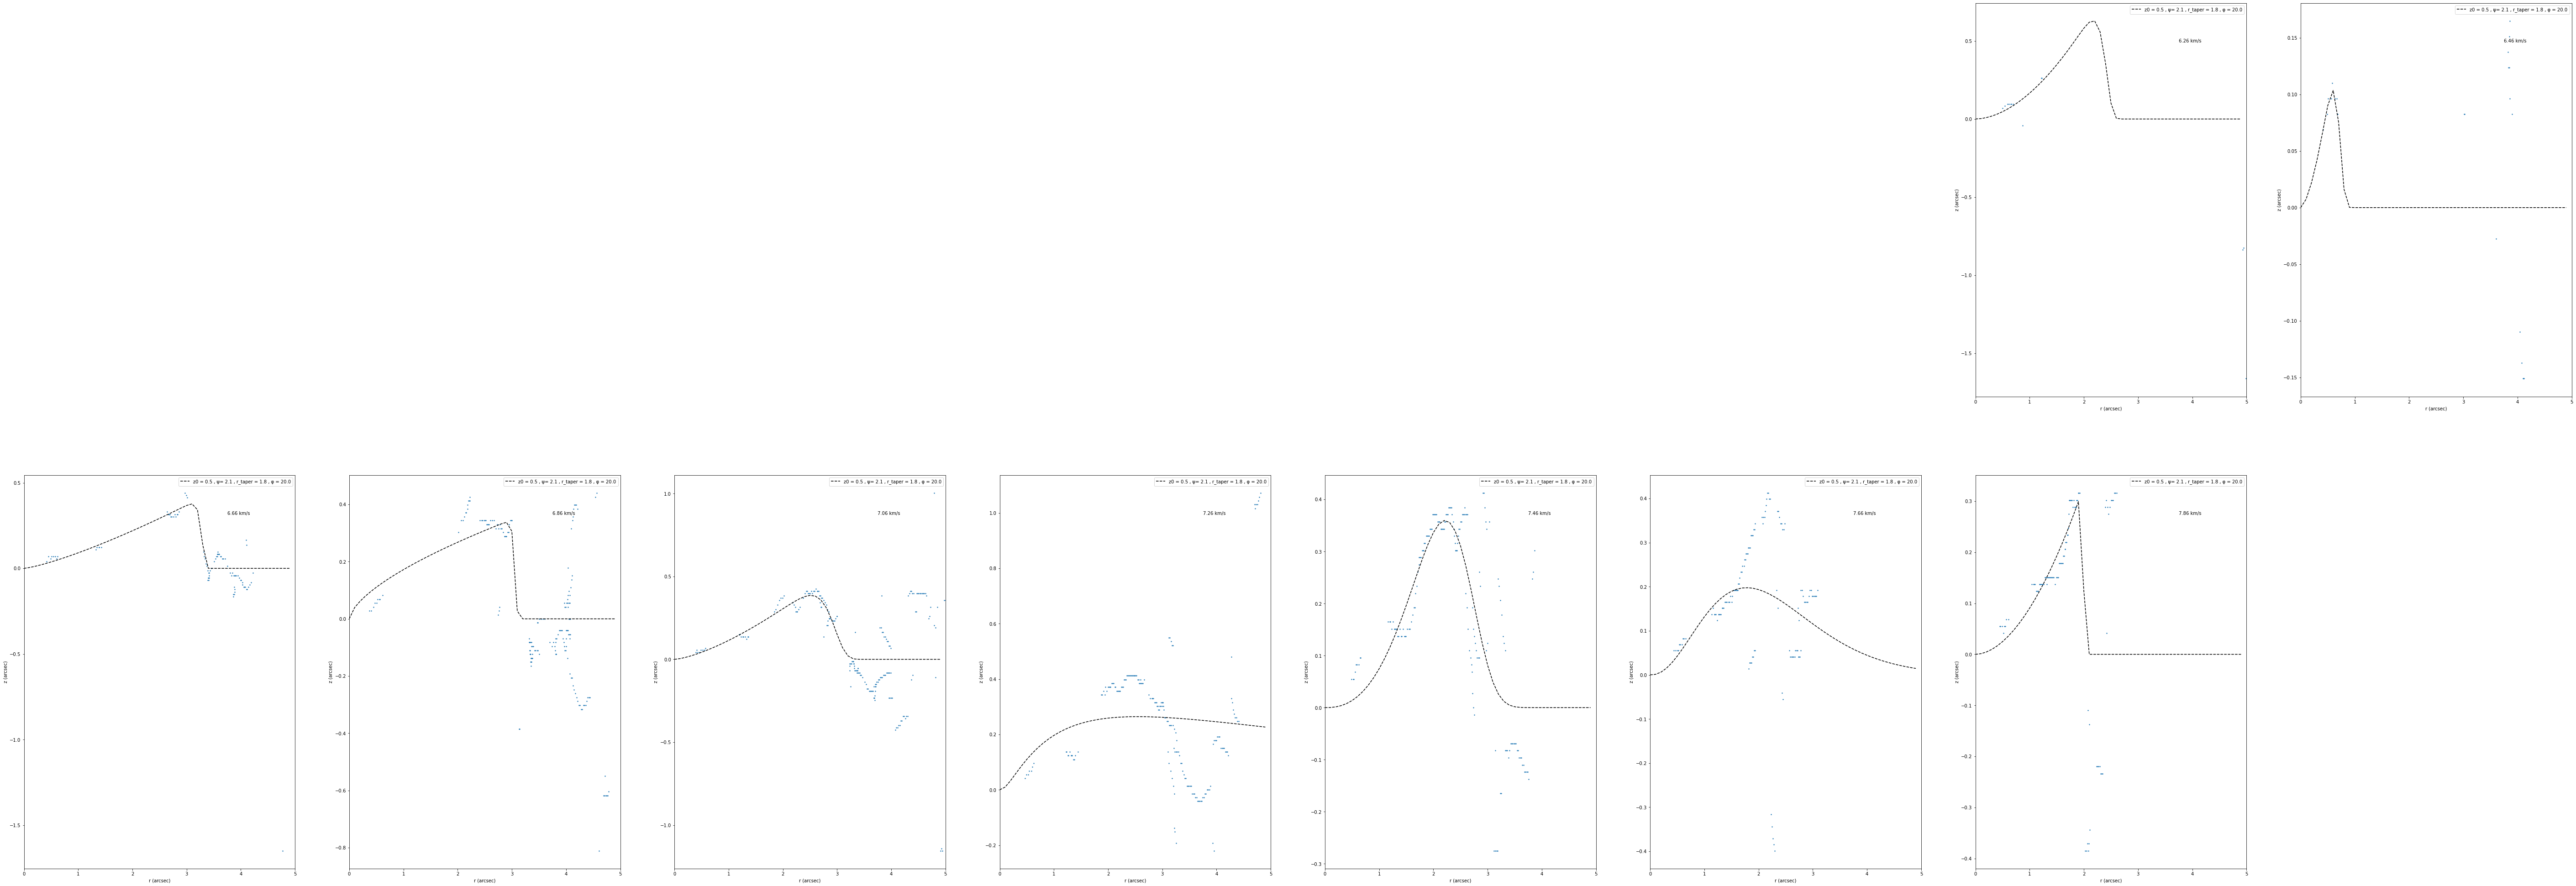

In [26]:
best_fit_curve_and_datapoints(path_6, r, z0_13co_2, Psi_13co_2, r_taper_13co_2, Phi_13co_2, color_array, c_lower_13co, c_upper_13co)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


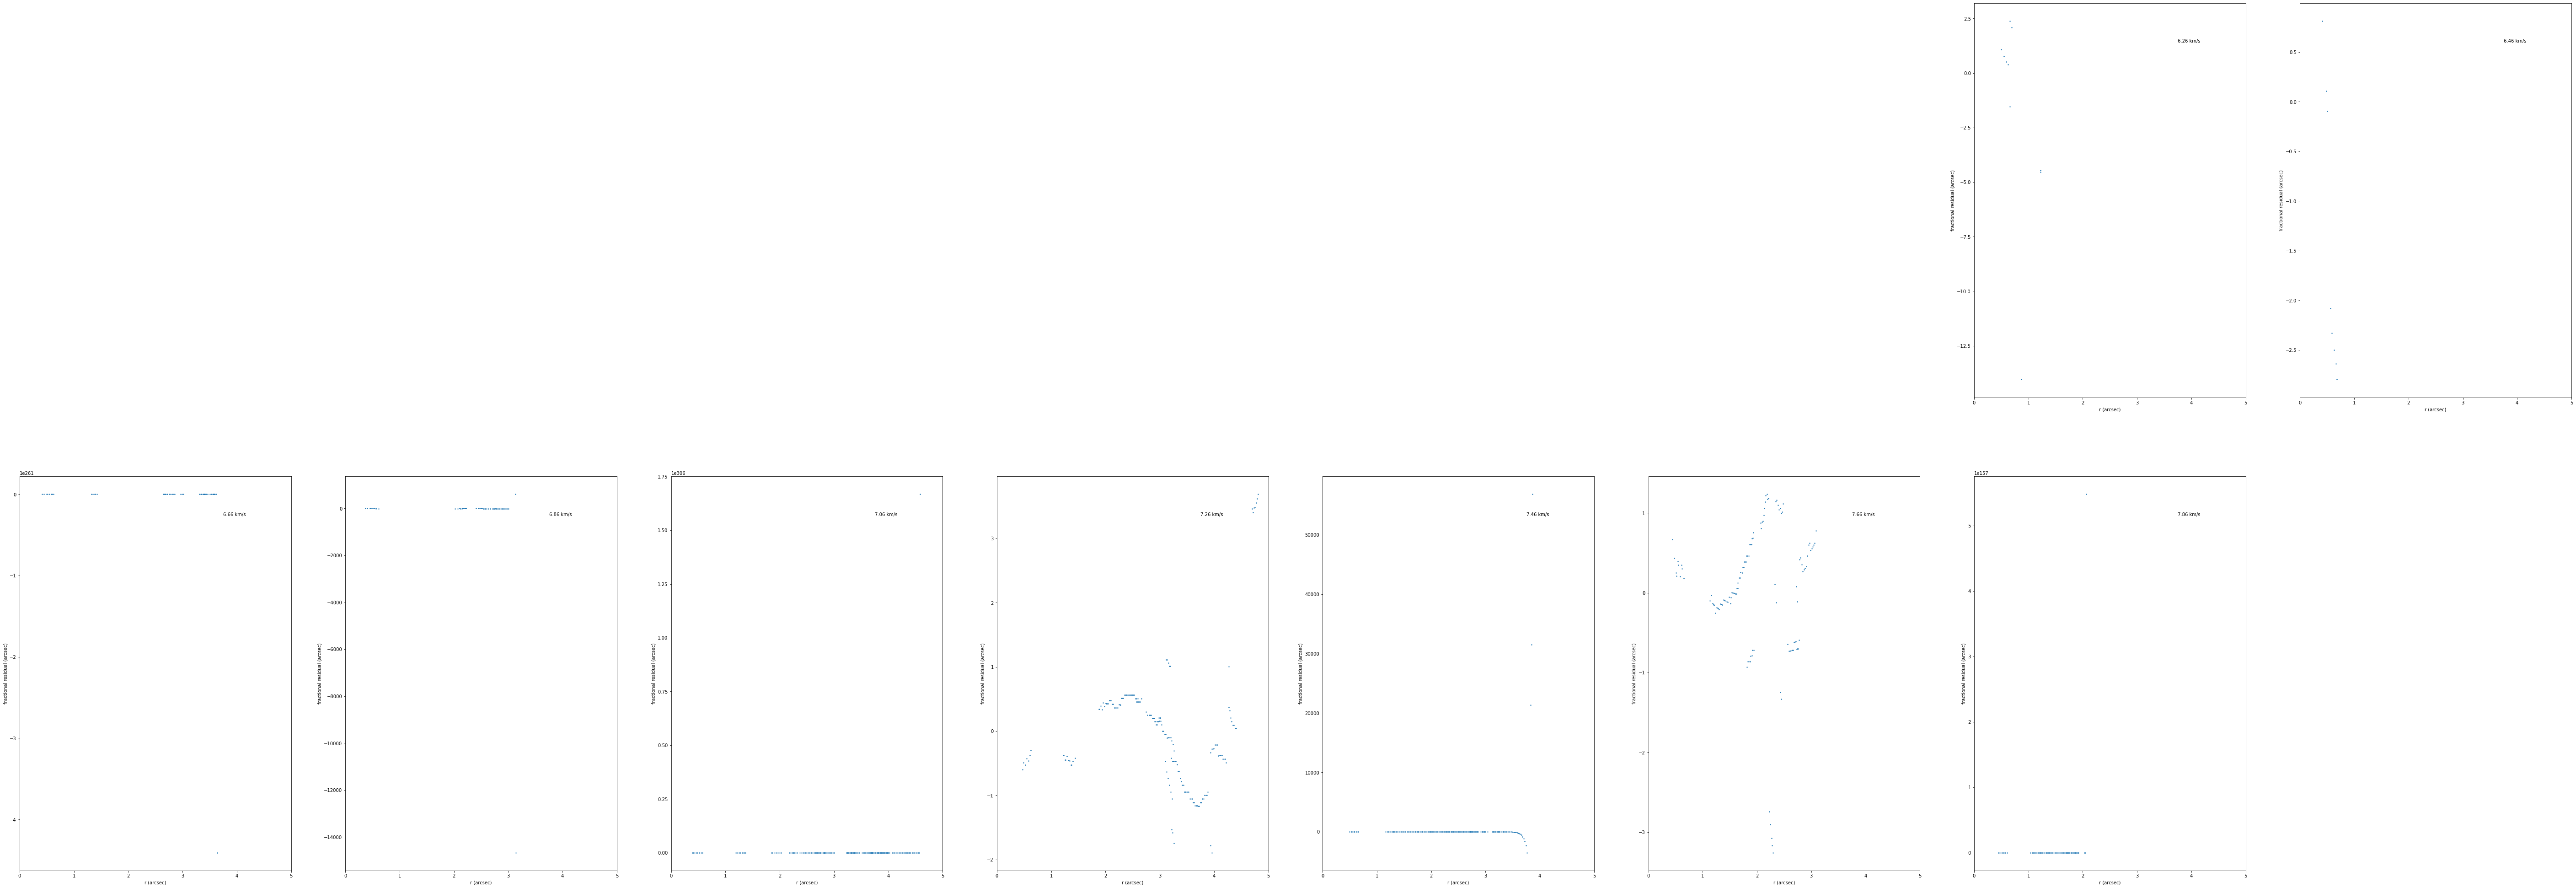

In [27]:
plotting_fractional_residual(path_6, r, z0_13co_2, Psi_13co_2, r_taper_13co_2, Phi_13co_2, c_lower_13co, c_upper_13co)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r

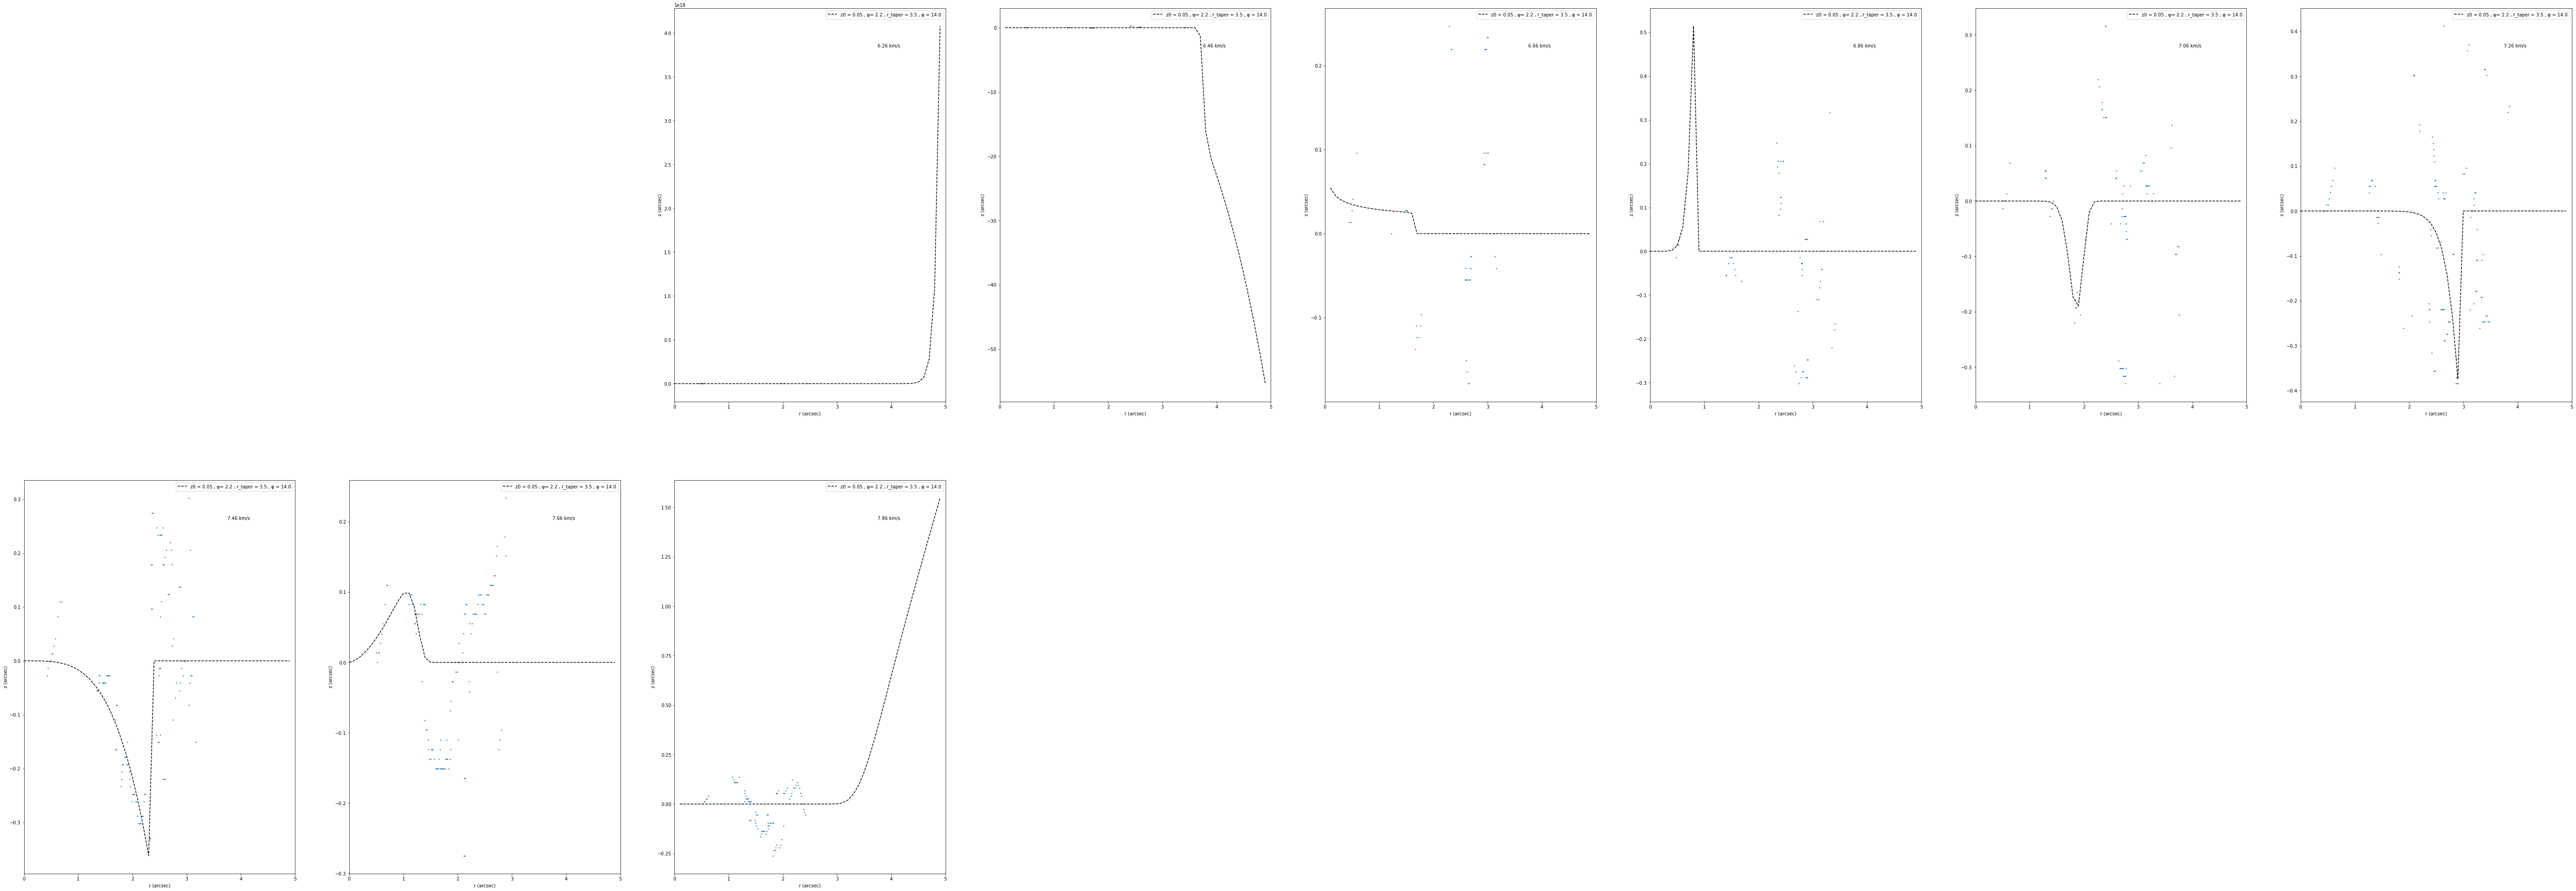

In [36]:
best_fit_curve_and_datapoints(path_7, r, z0_c18o, Psi_c18o, r_taper_c18o, Phi_c18o, color_array, c_lower_c18o, c_upper_c18o)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/data/shared/diskprojection/diskprojection/diskprojection.py:1062: RuntimeWarning: invalid value encountered in sqrt
  copt = np.diag(copt)**0.5
<ipython-input-1-4ba3db3a5e3c>:15: RuntimeWarning: overflow encountered in true_divide
  residual = (z_measured - z_model) / z_model


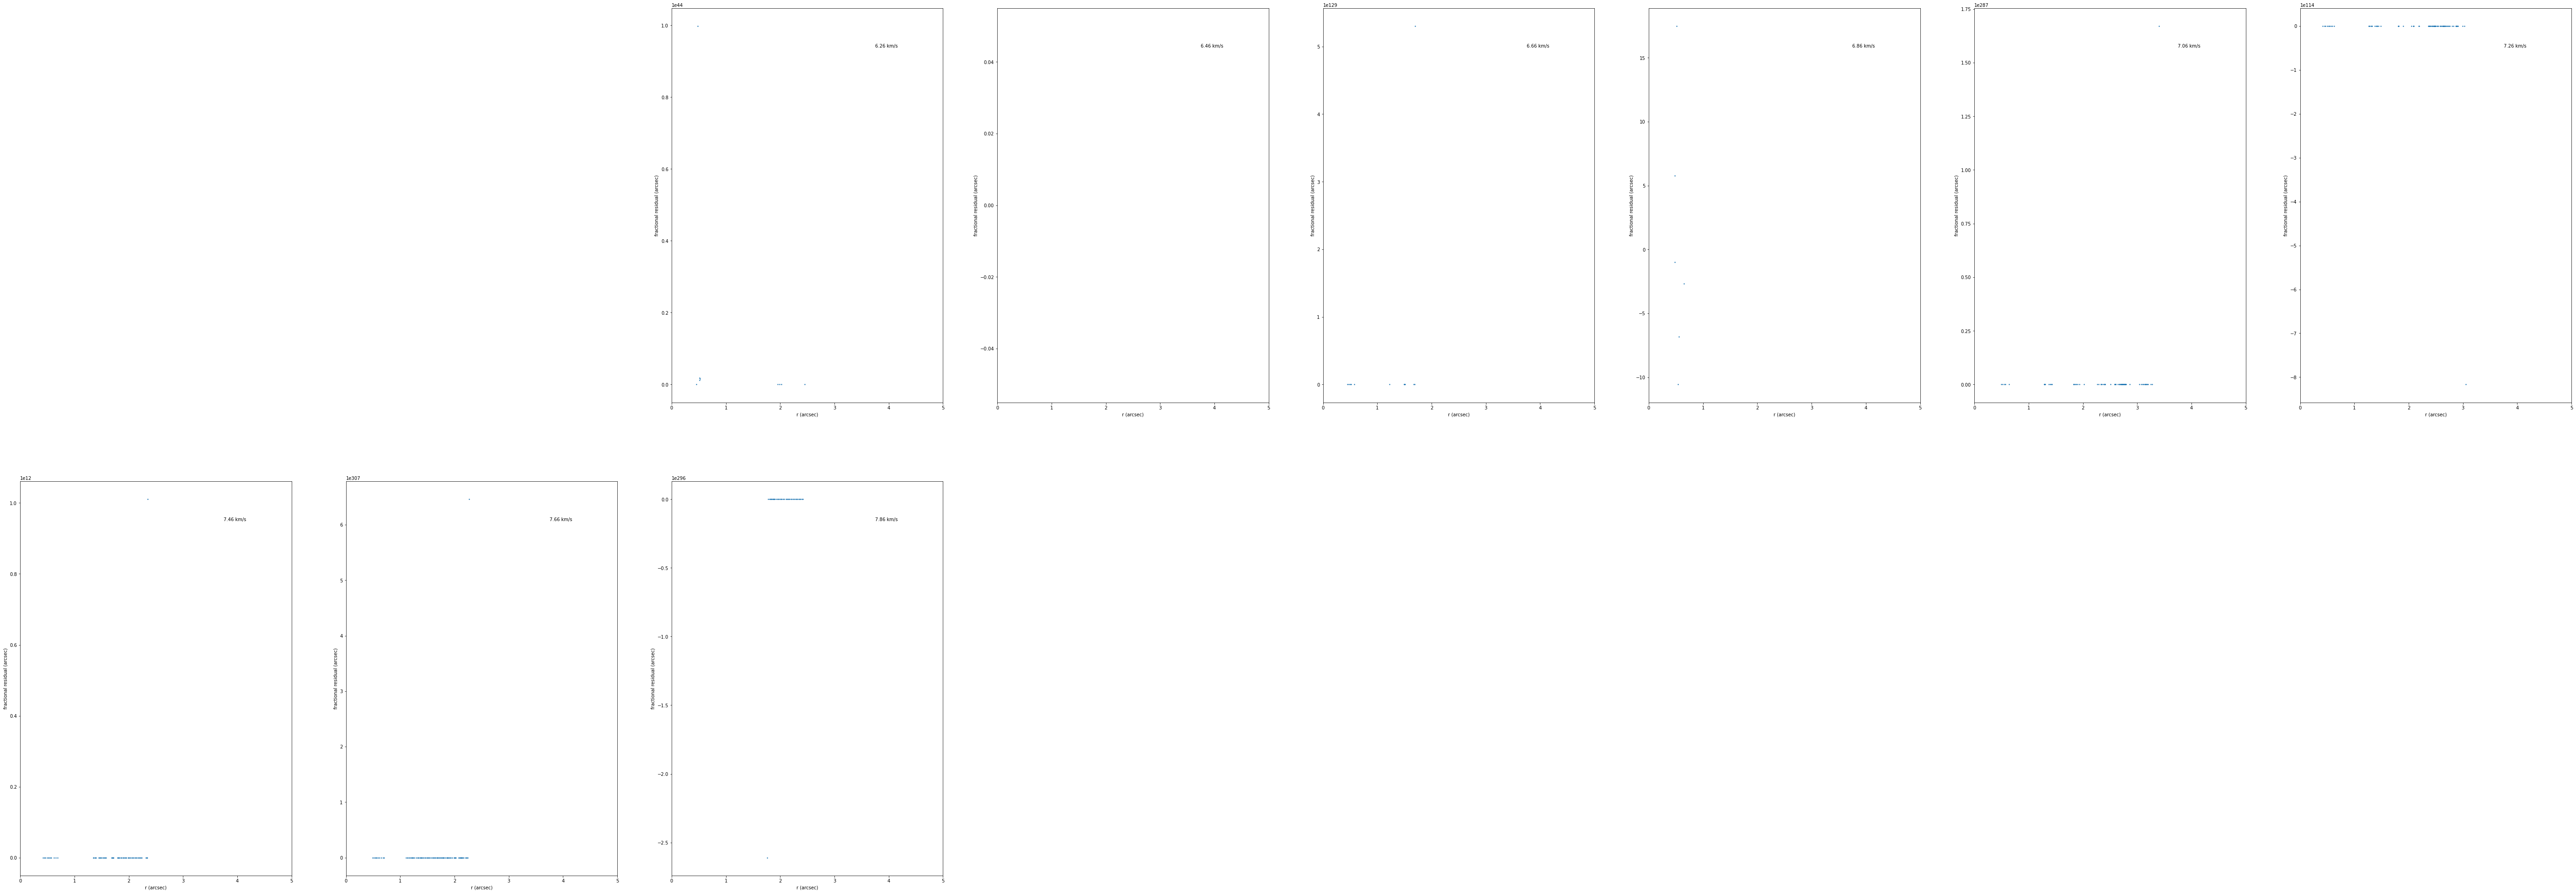

In [37]:
plotting_fractional_residual(path_7, r, z0_c18o, Psi_c18o, r_taper_c18o, Phi_c18o, c_lower_c18o, c_upper_c18o)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8

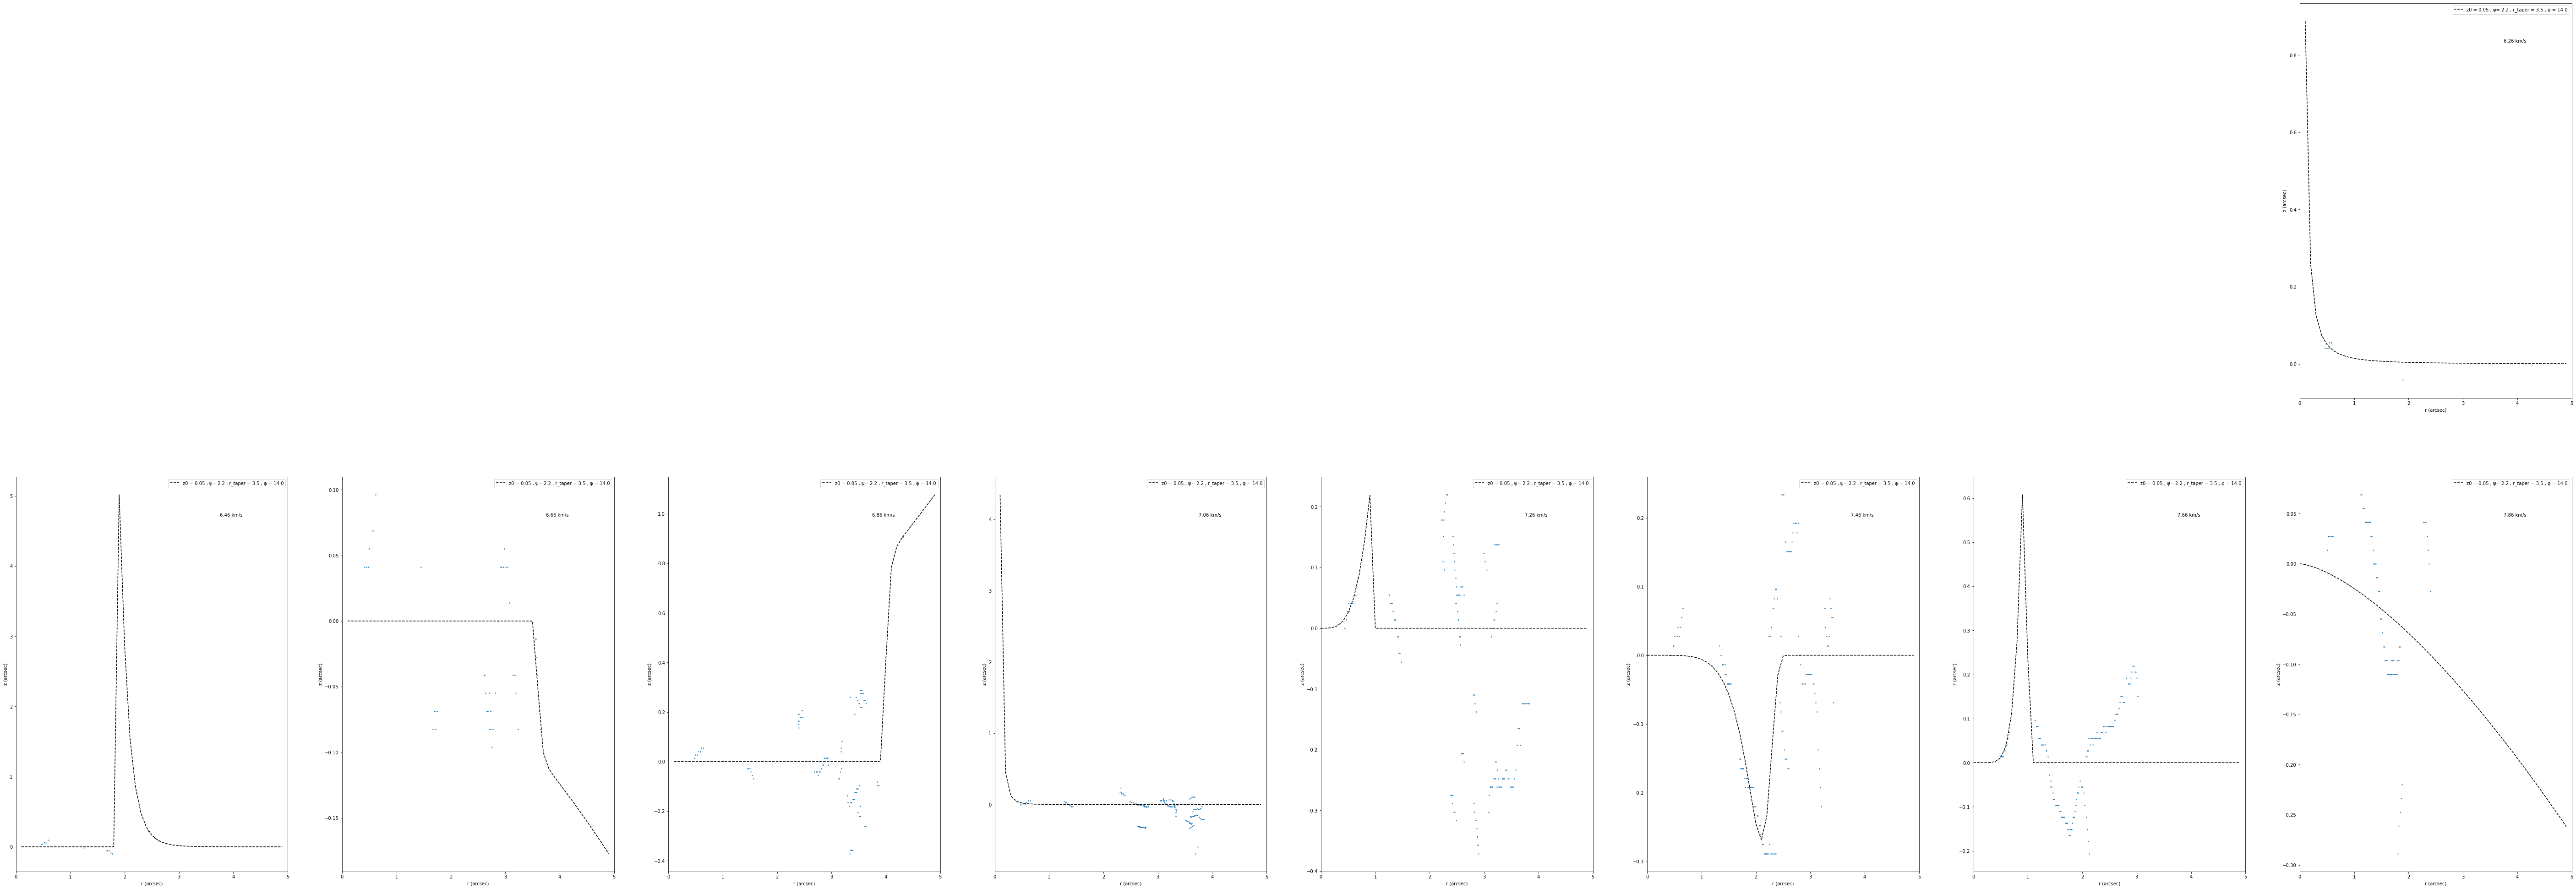

In [38]:
best_fit_curve_and_datapoints(path_8, r, z0_c18o, Psi_c18o, r_taper_c18o, Phi_c18o, color_array, c_lower_c18o, c_upper_c18o)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/data/shared/diskprojection/diskprojection/diskprojection.py:1415: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1062: RuntimeWarning: invalid value encountered in sqrt
  copt = np.diag(copt)**0.5
<ipython-input-1-4ba3db3a5e3c>:15: RuntimeWarning: overflow encountered in true_divide
  residual = (z_measured - z_model) / z_model


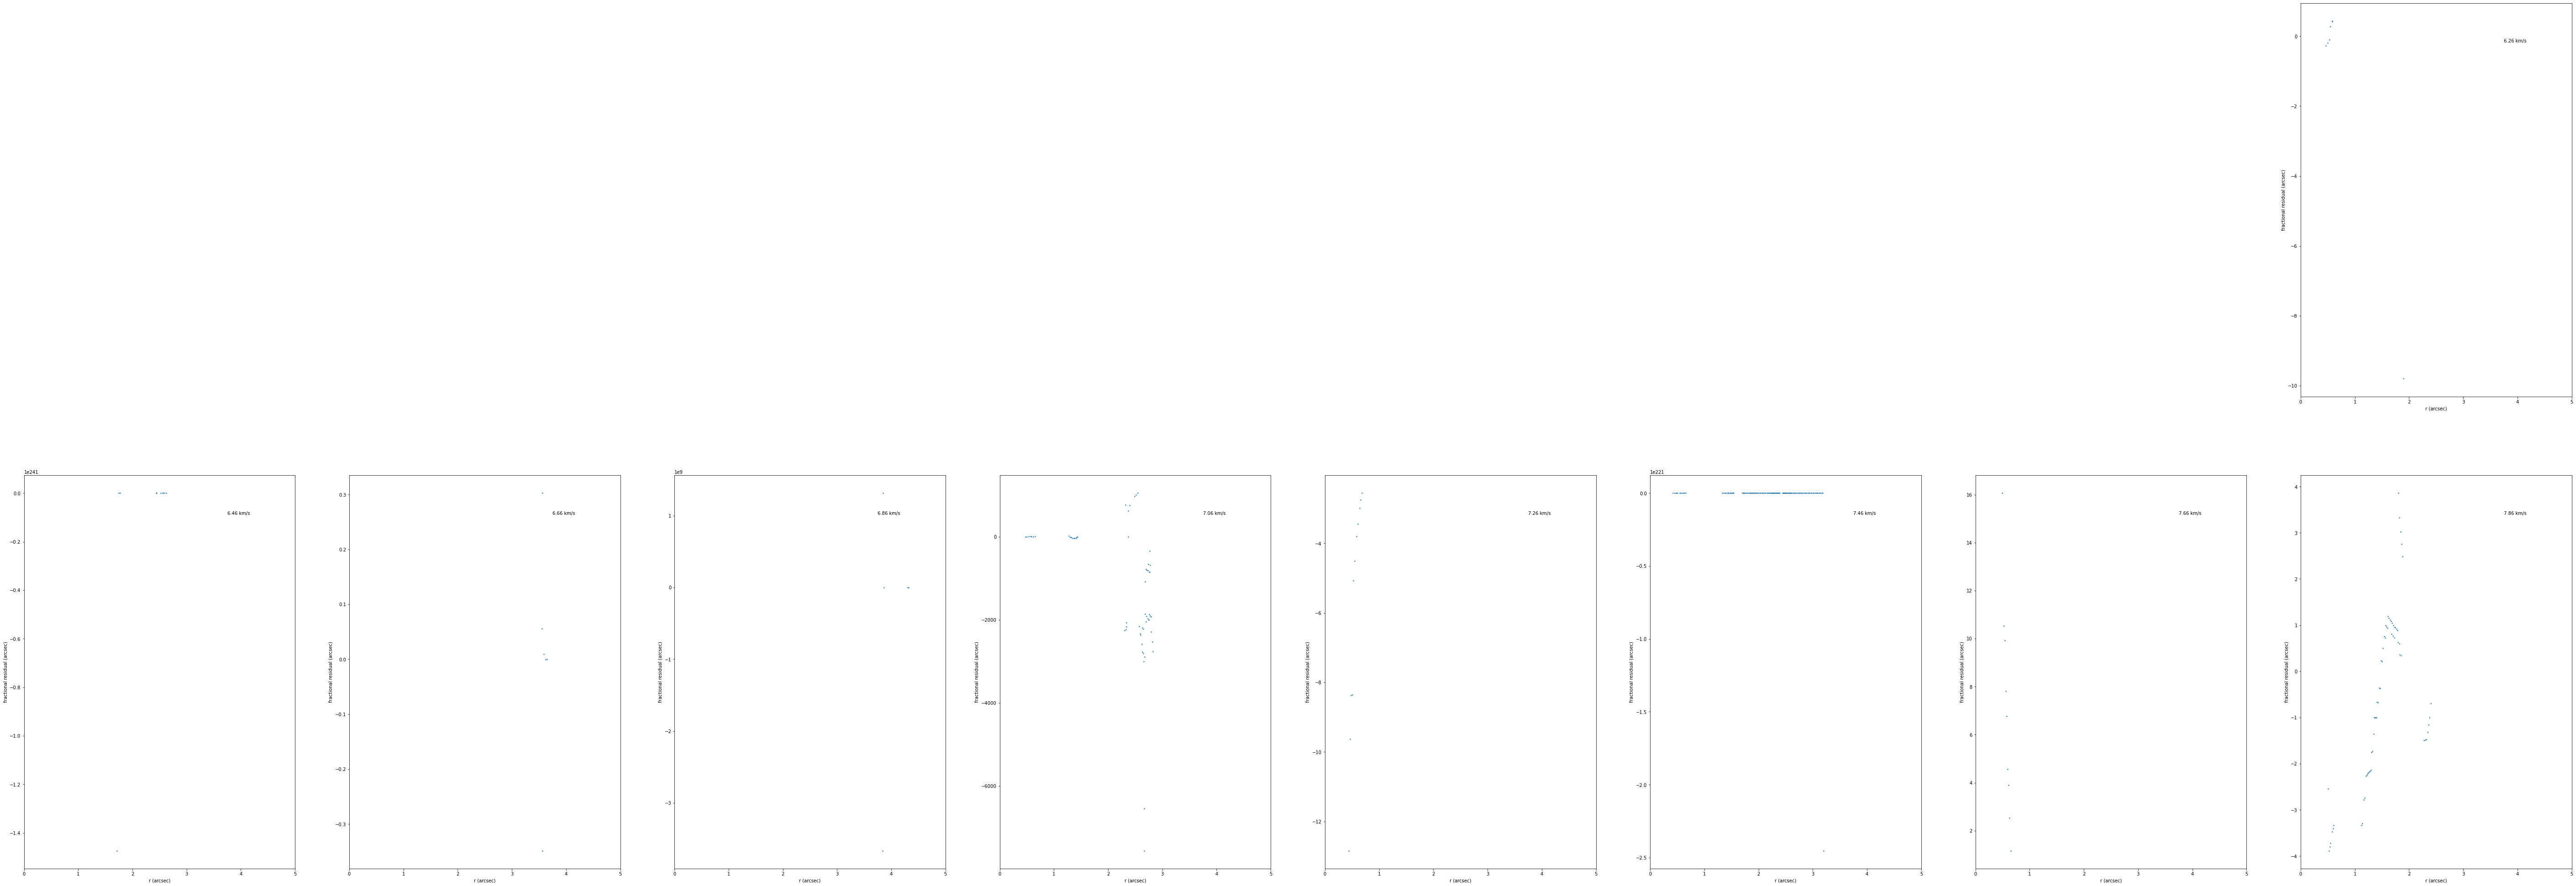

In [39]:
plotting_fractional_residual(path_8, r, z0_c18o, Psi_c18o, r_taper_c18o, Phi_c18o, c_lower_c18o, c_upper_c18o)

Test cases:

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation

HD163296_HCN = disk_observation('/data/shared/HD163296_MAPS/HD_163296_HCN_260GHz_hf1.robust_0.5.clean.JvMcorr.image.pbcor.fits')
#note that chans does NOT correspond to the channel maps
r, z, Fnu, velocity, x, yf, yn = HD163296_HCN.get_emission_surface_v2(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5, min_Fnu=.0025)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


In [58]:
rvals_tofit = r[np.where(velocity==HD163296_HCN.velax[69])]
zvals_tofit = z[np.where(velocity==HD163296_HCN.velax[69])]

print(rvals_tofit)
print(zvals_tofit)
zvals_tofit = zvals_tofit[np.where(z[np.where(velocity==HD163296_HCN.velax[69])]!=0)]
rvals_tofit = rvals_tofit[np.where(z[np.where(velocity==HD163296_HCN.velax[69])]!=0)]
print(zvals_tofit)
print(rvals_tofit)

[3.78569434 3.76821996 3.71956306 3.69483166 3.67010052 3.79756515
 3.77281783 3.74807057 3.78575485 3.68979946 3.67382907 3.56300168
 3.58943937 3.58206218 3.57484113 3.58561006 3.57885736 3.58138755
 3.71716319 3.84195169 3.50722105 3.49167574 3.63823838 3.61363452
 3.55967842 3.65429231 3.34651602 3.32181803 3.31589648 3.32923477
 3.31418227 3.3776431  3.36304518 3.34850308 3.32395864 3.31958927
 3.31539892 3.2503441  3.29722493 3.28312234 3.26908126 3.24466793
 3.22025976 3.35599863 3.34274241 3.21833971 3.20488853 3.14831224
 3.26464804 3.25188051 3.3303204  2.86297039 2.85022797 2.90597678
 2.9052492  2.90473234 2.83463168 2.78779473 2.75249596 2.66006567
 2.81008085 2.78654499 2.64589526 2.55314702 2.51787616 2.51692618
 2.50465914 2.44634431 2.43405022 2.41028718 2.48020709 2.45669691
 2.33034515 2.33180196 1.26333432 1.20214279 1.18029393 1.13220336
 1.12369233 1.10214872 1.09413518 1.07294192 1.06545969 1.0310311
 1.02402399 1.00358026 0.9971827  0.51032468 0.50401516 0.48436